In [21]:
import pickle5 as pickle
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import numpy as np

In [22]:
#lstm generator architecture
from torch import nn
from torch.nn.utils import spectral_norm


class AddDimension(nn.Module):
    def forward(self, x):
        return x.unsqueeze(1)


class SqueezeDimension(nn.Module):
    def forward(self, x):
        return x.squeeze(1)

#Banushev
# def create_critic_architecture():
#     return nn.Sequential(nn.Conv1d(1, 32, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.Conv1d(32, 64, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.BatchNorm1d(64),
#     nn.Conv1d(64, 128, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.BatchNorm1d(128),
#     nn.Linear (128, 220, bias=False), nn.BatchNorm1d(220), nn.LeakyReLU(0.01),
#     nn.Linear (220, 220, bias=False), nn.ReLU(),
#     nn.Linear(220, 1))
                         

def create_critic_architecture():
    return nn.Sequential(AddDimension(),
                         spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         
                         
                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         

                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.Flatten(),

                         nn.Linear(32, 50),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(50, 15),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(15, 1)
                         )


class Generator(nn.Module):
    def __init__(self, num_embed=20, num_hidden=500, num_layers=1, sequence_length=17, output_size = 1, bidirectional=False):
        
        nn.Module.__init__(self)
        
        self.num_hidden = num_hidden
        
        self.rnn = nn.LSTM(num_embed, num_hidden, num_layers, bidirectional=bidirectional)
        self.decoder = nn.Linear(num_hidden, output_size)
    
    def forward(self, inputs):
        output, hidden = self.rnn(inputs)
        decoded = self.decoder(output)
        return decoded
    


class Critic(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.main = create_critic_architecture()

    def forward(self, inputs):
        return self.main(inputs)

In [3]:
ticker_data_file = 'data/ticker_data.xlsx'
ticker_data = pd.read_excel(ticker_data_file)
tickers = ticker_data['Symbol'].to_list()
tickers_str = ''
for ticker in tickers:
    #delisted
    if (ticker != 'BRK.B'):
        tickers_str = tickers_str + ticker + ' '
tickers_str = tickers_str[:len(tickers_str)-1]
tickers.remove('BRK.B')

In [4]:
price_data = yf.download( 
        tickers = tickers_str,
        start="2018-01-01", end="2020-12-31",
        interval = "1d",
        group_by = 'ticker',
        auto_adjust = True,
        prepost = False,
        threads = True,
        proxy = None)

[*********************100%***********************]  49 of 49 completed


In [5]:
price_df = pd.DataFrame({})
for tick in tickers:
    df = price_data[tick]['Open']
    price_df[tick] = df

In [6]:
#inspect na, remove paypal
price_df.isnull().sum()
price_df = price_df.drop (['PYPL'],axis=1)

In [7]:
#technical indicators
factor_list = ['macd', 'mom', 'rsi', 'slope', 'stoch', 'sma', 'vwap', 'mad', 'stdev', 'variance', 'bbands', 'adx', 'entropy', 'stochrsi']

In [8]:
#technical indicators
factor_data = {}
for factor_name in factor_list:
    try:
        factor_df = pd.DataFrame({})
        shift = True
        for tick in price_df.columns:
            ta_df = price_data[tick]
            factor_df[tick] = getattr(ta_df.copy().ta, factor_name)()
        factor_df = factor_df.shift(int(shift))
        factor_data[factor_name] = factor_df
    except:
        continue

In [9]:
#remaining factors
print (factor_data.keys())

dict_keys(['mom', 'rsi', 'slope', 'sma', 'vwap', 'mad', 'stdev', 'variance', 'entropy'])


In [10]:
#fourier transform
fourier_df = pd.DataFrame({}, index = price_data.index)
for tick in price_df.columns:
    df = price_data[tick]['Close']
    
    fourier_df[tick] = np.fft.fft(np.asarray(df.tolist()))
# factor_df = factor_df.stack()
# factor_df.index = factor_df.index.set_names(['date', 'asset'])

In [11]:
for tick in price_df.columns:
    fft_list = fourier_df[tick]
    num = 3
    fft_list_m10= np.copy(fft_list); 
    fft_list_m10[num:-num]=0
    ifft = np.fft.ifft(fft_list_m10)
    fourier_df[tick] = ifft

In [12]:
#create data to use 
data_final = pd.DataFrame(index = price_df.index)
data_final['AAPL'] = price_df['AAPL']
for i, ticker in enumerate(price_df.columns):
    if (i < 10):
        data_final[ticker] = price_df[ticker]
        
data_final['Fourier'] = fourier_df['AAPL']
for factor in factor_data.keys():
    data_final[factor] = factor_data[factor]['AAPL']
data_final = data_final.dropna(how = 'any', axis = 0)




In [13]:
#turn data into their format
data_final_list = []
example_size = 18
for i in range (data_final.shape[0]-example_size):
    example = data_final.iloc[i:example_size+i].to_dict('series')
    for key in example.keys():
        example[key] = example[key].astype('float').to_list()
    data_final_list.append(example)

/Users/Nick/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1097: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


In [14]:
len(data_final_list)

707

In [15]:
train_data_proportion = int(.8*len(data_final_list))
train_data = data_final_list[:train_data_proportion]
test_data = data_final_list[train_data_proportion:]

In [16]:
import argparse
import os


import torch
from tqdm import tqdm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from math import pi

In [50]:
from sklearn.metrics import mean_absolute_error
#historical averaging
class Trainer:
    NOISE_LENGTH = 50

    def __init__(self, total_batches, average_param_size_gen, average_param_size_crit, generator, critic, gen_optimizer, critic_optimizer,
                 gp_weight=10, ha_weight = .01, critic_iterations=5, print_every=50, use_cuda=False, checkpoint_frequency=200):
        self.g = generator
        self.g_opt = gen_optimizer
        self.c = critic
        self.c_opt = critic_optimizer
        self.losses = {'g': [], 'c': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every
        self.checkpoint_frequency = checkpoint_frequency
        
        self.total_batches = total_batches
        self.average_param_size_gen = average_param_size_gen
        self.average_param_size_crit = average_param_size_crit
        self.ha_weight = .01

        if self.use_cuda:
            self.g.cuda()
            self.c.cuda()

    def _critic_train_iteration(self, data):
    
        #My code
        #create generator data
        data_size = len(data['AAPL']) - 1
        generator_data = []
        for key in data.keys():
            generator_data.append([t.numpy() for t in data[key][:data_size]])
        generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
        generator_data = generator_data.permute(1, 2, 0)
        
       
        #create critic data
        critic_data = torch.from_numpy(np.array([t.numpy() for t in data['AAPL'][data_size:]]).astype('float64'))
        critic_data = Variable(critic_data)
        critic_data = critic_data.permute (1, 0)
        
        
        generated_data = self.g(generator_data.float()) 
        # Get gradient penalty
#         print (generated_data.shape)
        generated_data = torch.unsqueeze(torch.squeeze(generated_data, 2).permute(1,0)[:,16], 1)

        # Pass data through the Critic
#         print (critic_data.shape)
#         print (generated_data.shape)
        
        c_real = self.c(critic_data.float())
        c_generated = self.c(generated_data.float())

#       
#         print ('here')
#         print (generated_data.shape)
#         print (critic_data.shape)

       

        gradient_penalty = self._gradient_penalty(critic_data, generated_data)
        self.losses['GP'].append(gradient_penalty.data.item())
        
        self.c_opt.zero_grad()
        
        #calculate historical average loss
        total_c_params = 0
        #calc average param size
        for param in self.c.parameters():
            total_c_params += torch.norm(param, p=2).detach()
        new_param_size = total_c_params

        cur_average_param_size_crit = self.average_param_size_crit
        self.average_param_size_crit = (self.average_param_size_crit+ new_param_size)/self.total_batches
        hist_avg_loss = self.ha_weight*(new_param_size-cur_average_param_size_crit)**2
#         print ('hist_av')
#         print (hist_avg_loss)
        
#         print ('normal')
#         print ( c_generated.mean() - c_real.mean() + gradient_penalty)
        

        # Create total loss and optimize
        
        d_loss = c_generated.mean() - c_real.mean() + gradient_penalty + hist_avg_loss
        d_loss.backward()
        self.c_opt.step()

        self.losses['c'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        self.g_opt.zero_grad()
        
        #create generator data
        data_size = len(data['AAPL']) - 1
        generator_data = []
        for key in data.keys():
            generator_data.append([t.numpy() for t in data[key][:data_size]])
        generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
        generator_data = generator_data.permute(1, 2, 0)
        generator_result= self.g(generator_data.float())
        
        
        generator_result = torch.unsqueeze(torch.squeeze(generator_result, 2).permute(1,0)[:,16], 1)
        
        # Calculate loss and optimize
        d_generated = self.c(generator_result.float())
        
        
        #historical average loss
        
        total_g_params = 0
        #calc average param size
        for param in self.g.parameters():
            total_g_params += torch.norm(param, p=2).detach()
        new_param_size = total_g_params

        cur_average_param_size_gen = self.average_param_size_gen
        self.average_param_size_gen = (self.average_param_size_gen+ new_param_size)/self.total_batches
        hist_avg_loss = self.ha_weight*(new_param_size-cur_average_param_size_gen)**2
        
        g_loss = - d_generated.mean() + hist_avg_loss
        g_loss.backward()
        self.g_opt.step()
        self.losses['g'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):
        
#         print (real_data.shape)
#         print (generated_data.shape)
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        interpolated = Variable(interpolated, requires_grad=True)
#         print (interpolated.shape)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Pass interpolated data through Critic
        prob_interpolated = self.c(interpolated.float())

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda
                               else torch.ones(prob_interpolated.size()), create_graph=True,
                               retain_graph=True)[0]
        # Gradients have shape (batch_size, num_channels, series length),
        # here we flatten to take the norm per example for every batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())

        # Derivatives of the gradient close to 0 can cause problems because of the
        # square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader, epoch, writer):
        for i, data in enumerate(data_loader):
            
            #my code 
            data_size = 100
            #print (len(data['AAPL']))
            
            
            self.num_steps += 1
            self.total_batches += 1
            
            
            self._critic_train_iteration(data)
            # Only update generator every critic_iterations iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data)

            if i % self.print_every == 0:
                global_step = i + epoch * len(data_loader.dataset)
                writer.add_scalar('Losses/Critic', self.losses['c'][-1], global_step)
                writer.add_scalar('Losses/Gradient Penalty', self.losses['GP'][-1], global_step)
                writer.add_scalar('Gradient Norm', self.losses['gradient_norm'][-1], global_step)

                if self.num_steps > self.critic_iterations:
                    writer.add_scalar('Losses/Generator', self.losses['g'][-1], global_step)

    def train(self, data_loader, data_list, epochs, plot_training_samples=True, checkpoint=None, writer=None):
        
        eval_data = []
        for data in test_data:
            generator_data = []
            for key in data.keys():
                generator_data.append(data[key])
            generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
            generator_data = torch.unsqueeze (generator_data, 0)
            data_cur = generator_data.permute(2, 0, 1)
            eval_data.append(data_cur)
        
        if checkpoint:
            path = os.path.join('checkpoints', checkpoint)
            state_dicts = torch.load(path, map_location=torch.device('cpu'))
            self.g.load_state_dict(state_dicts['g_state_dict'])
            self.c.load_state_dict(state_dicts['d_state_dict'])
            self.g_opt.load_state_dict(state_dicts['g_opt_state_dict'])
            self.c_opt.load_state_dict(state_dicts['d_opt_state_dict'])
       
#         # Define noise_shape
#         noise_shape = (1, self.NOISE_LENGTH)
        
#         if plot_training_samples:
#             # Fix latents to see how series generation improves during training
#             fixed_latents = Variable(self.sample_latent(noise_shape))
#             if self.use_cuda:
#                 fixed_latents = fixed_latents.cuda()

        #my code
        self.g = self.g.float()
        self.c = self.c.float()
        
        
        
        returns_generated = []
        returns_true = []
        MAE_list = []
        
        for epoch in tqdm(range(epochs)):

#             # Sample a different region of the latent distribution to check for mode collapse
#             dynamic_latents = Variable(self.sample_latent(noise_shape))
#             if self.use_cuda:
#                 dynamic_latents = dynamic_latents.cuda()
            
            self._train_epoch(data_loader, epoch + 1, writer)

#             # Save checkpoint
#             if epoch % self.checkpoint_frequency == 0:
#                 torch.save({
#                     'epoch': epoch,
#                     'd_state_dict': self.c.state_dict(),
#                     'g_state_dict': self.g.state_dict(),
#                     'd_opt_state_dict': self.c_opt.state_dict(),
#                     'g_opt_state_dict': self.g_opt.state_dict(),
#                 }, 'checkpoints/epoch_{}.pkl'.format(epoch))

            if plot_training_samples and (epoch % self.print_every == 0):
                self.g.eval()
            
                # Generate eval result (last sample period)
                returns_generated = []
                returns_true = []
                for data in eval_data:
                    train = data[:17, :, :]
                    true_val = data[17, :, 0]
                    generator_result= self.g(train.float())
                    generator_result = torch.squeeze(generator_result, 2).permute(1,0)[:,16]
                    returns_generated.append(generator_result.detach().numpy()[0])
                    returns_true.append(true_val.numpy()[0])
                MAE = mean_absolute_error(returns_true, returns_generated)
                MAE_list.append(MAE)
                    
                print ("MAE")
                print (MAE)
                print ()
                
                plt.figure()
                plt.plot(returns_generated, label = 'generated')
                plt.plot (returns_true, label = 'true')
                plt.show()
                #plt.savefig('training_samples/fixed_latents/series_epoch_{}.png'.format(epoch))
                plt.close()

#                 plt.figure()
#                 plt.plot(fake_data_dynamic_latents.numpy()[0].T)
#                 #plt.savefig('training_samples/dynamic_latents/series_epoch_{}.png'.format(epoch))
#                 plt.show()
#                 plt.close()
                self.g.train()
        return returns_generated, returns_true
#     def sample_generator(self, latent_shape):
#         latent_samples = Variable(self.sample_latent(latent_shape))
#         if self.use_cuda:
#             latent_samples = latent_samples.cuda()

#         return self.g(latent_samples)

    @staticmethod
    def sample_latent(shape):
        return torch.randn(shape)

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        return generated_data.data.cpu().numpy()


def run_GAN():
    
    #historical averaging
    average_param_size_gen = 0
    average_param_size_crit = 0
    total_batches = 0


    batch_size = 16
    epochs = 5000
    log_name = 'tensorboard_log_name'
    checkpoint = None
    

    # Instantiate Generator and Critic + initialize weights
    g = Generator()

    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.00005)
    d = Critic()
    
    #calc average param size
    total_g_params = 0
    for param in g.parameters():
        total_g_params += torch.norm(param, p=2).detach().numpy()
    average_param_size_gen = total_g_params
    
    total_c_params = 0
    #calc average param size
    for param in d.parameters():
        total_c_params += torch.norm(param, p=2).detach().numpy()
    average_param_size_crit = total_c_params
        

    d_opt = torch.optim.RMSprop(d.parameters(), lr=0.00005)
    
    #Create Dataloader
    dataset = train_data
    dataloader = DataLoader(dataset, batch_size=batch_size)


    # Instantiate Trainer
    trainer = Trainer(total_batches, average_param_size_gen, average_param_size_crit, g, d, g_opt, d_opt, use_cuda=torch.cuda.is_available())
    # Train model
    print('Training is about to start...')
    # Instantiate Tensorboard writer
    tb_logdir = os.path.join('..', 'tensorboard', log_name)
    writer = SummaryWriter(tb_logdir)

    returns = trainer.train(dataloader, data_final_list, epochs=epochs, plot_training_samples=True, checkpoint=checkpoint, writer=writer)
    return returns







  0%|          | 0/5000 [00:00<?, ?it/s]

Training is about to start...
MAE
110.43937539897169



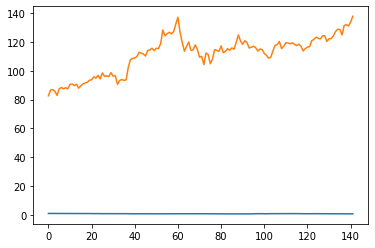







  0%|          | 1/5000 [00:08<11:13:03,  8.08s/it]





  0%|          | 2/5000 [00:14<10:38:27,  7.66s/it]





  0%|          | 3/5000 [00:21<10:08:30,  7.31s/it]





  0%|          | 4/5000 [00:27<9:47:33,  7.06s/it] 





  0%|          | 5/5000 [00:34<9:36:28,  6.92s/it]





  0%|          | 6/5000 [00:40<9:27:11,  6.81s/it]





  0%|          | 7/5000 [00:47<9:27:54,  6.82s/it]





  0%|          | 8/5000 [00:54<9:27:52,  6.83s/it]





  0%|          | 9/5000 [01:01<9:25:52,  6.80s/it]





  0%|          | 10/5000 [01:08<9:31:53,  6.88s/it]





  0%|          | 11/5000 [01:15<9:30:05,  6.86s/it]





  0%|          | 12/5000 [01:22<9:31:30,  6.87s/it]





  0%|          | 13/5000 [01:28<9:24:49,  6.80s/it]





  0%|          | 14/5000 [01:35<9:19:54,  6.74s/it]





  0%|          | 15/5000 [01:41<9:17:41,  6.71s/it]





  0%|          | 16/5000 [01:48<9:07:41,  6.59s/it]





  0%|          | 17/5000 [01:54<9:01:45,  6.52s/it]





  0%|          | 18/5000 [02:0

MAE
104.61898383005239



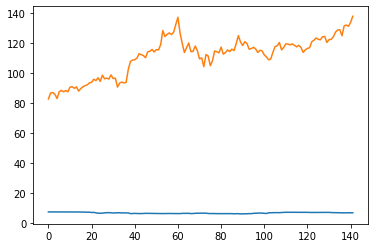







  1%|          | 51/5000 [05:38<9:29:00,  6.90s/it]





  1%|          | 52/5000 [05:45<9:21:03,  6.80s/it]





  1%|          | 53/5000 [05:52<9:18:54,  6.78s/it]





  1%|          | 54/5000 [05:58<9:17:10,  6.76s/it]





  1%|          | 55/5000 [06:05<9:17:07,  6.76s/it]





  1%|          | 56/5000 [06:12<9:10:51,  6.69s/it]





  1%|          | 57/5000 [06:18<9:06:58,  6.64s/it]





  1%|          | 58/5000 [06:25<9:04:34,  6.61s/it]





  1%|          | 59/5000 [06:31<9:03:02,  6.59s/it]





  1%|          | 60/5000 [06:38<9:03:37,  6.60s/it]





  1%|          | 61/5000 [06:44<8:59:55,  6.56s/it]





  1%|          | 62/5000 [06:51<8:59:18,  6.55s/it]





  1%|▏         | 63/5000 [06:57<8:58:44,  6.55s/it]





  1%|▏         | 64/5000 [07:04<8:58:30,  6.55s/it]





  1%|▏         | 65/5000 [07:10<9:00:18,  6.57s/it]





  1%|▏         | 66/5000 [07:17<8:57:04,  6.53s/it]





  1%|▏         | 67/5000 [07:23<8:56:04,  6.52s/it]





  1%|▏         | 68/5000 

MAE
101.73209902319104



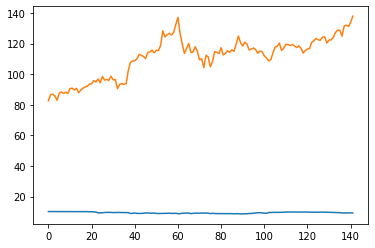







  2%|▏         | 101/5000 [11:07<9:42:25,  7.13s/it]





  2%|▏         | 102/5000 [11:14<9:31:22,  7.00s/it]





  2%|▏         | 103/5000 [11:21<9:24:45,  6.92s/it]





  2%|▏         | 104/5000 [11:28<9:17:37,  6.83s/it]





  2%|▏         | 105/5000 [11:34<9:12:36,  6.77s/it]





  2%|▏         | 106/5000 [11:41<9:09:10,  6.73s/it]





  2%|▏         | 107/5000 [11:47<9:08:25,  6.73s/it]





  2%|▏         | 108/5000 [11:54<9:00:23,  6.63s/it]





  2%|▏         | 109/5000 [12:01<9:00:27,  6.63s/it]





  2%|▏         | 110/5000 [12:07<9:00:34,  6.63s/it]





  2%|▏         | 111/5000 [12:14<8:55:08,  6.57s/it]





  2%|▏         | 112/5000 [12:20<8:54:08,  6.56s/it]





  2%|▏         | 113/5000 [12:27<8:50:10,  6.51s/it]





  2%|▏         | 114/5000 [12:33<8:47:44,  6.48s/it]





  2%|▏         | 115/5000 [12:39<8:49:04,  6.50s/it]





  2%|▏         | 116/5000 [12:46<8:40:07,  6.39s/it]





  2%|▏         | 117/5000 [12:52<8:41:17,  6.41s/it]





  2%|▏  

MAE
99.1836855920503



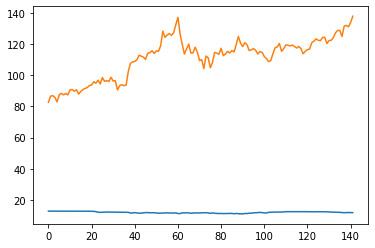







  3%|▎         | 151/5000 [16:29<9:06:58,  6.77s/it]





  3%|▎         | 152/5000 [16:35<8:54:58,  6.62s/it]





  3%|▎         | 153/5000 [16:41<8:46:50,  6.52s/it]





  3%|▎         | 154/5000 [16:48<8:39:30,  6.43s/it]





  3%|▎         | 155/5000 [16:54<8:39:22,  6.43s/it]





  3%|▎         | 156/5000 [17:00<8:35:26,  6.38s/it]





  3%|▎         | 157/5000 [17:07<8:34:49,  6.38s/it]





  3%|▎         | 158/5000 [17:13<8:35:13,  6.38s/it]





  3%|▎         | 159/5000 [17:19<8:33:56,  6.37s/it]





  3%|▎         | 160/5000 [17:26<8:32:04,  6.35s/it]





  3%|▎         | 161/5000 [17:32<8:24:04,  6.25s/it]





  3%|▎         | 162/5000 [17:38<8:21:35,  6.22s/it]





  3%|▎         | 163/5000 [17:44<8:20:55,  6.21s/it]





  3%|▎         | 164/5000 [17:51<8:27:02,  6.29s/it]





  3%|▎         | 165/5000 [17:57<8:38:03,  6.43s/it]





  3%|▎         | 166/5000 [18:04<8:45:34,  6.52s/it]





  3%|▎         | 167/5000 [18:11<8:56:24,  6.66s/it]





  3%|▎  

MAE
96.57708557611454



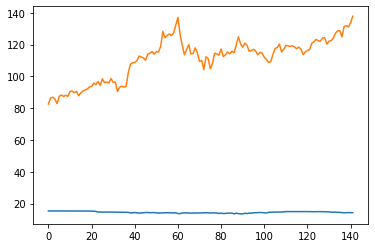







  4%|▍         | 201/5000 [22:26<10:37:49,  7.97s/it]





  4%|▍         | 202/5000 [22:34<10:28:55,  7.86s/it]





  4%|▍         | 203/5000 [22:41<10:23:51,  7.80s/it]





  4%|▍         | 204/5000 [22:50<10:36:49,  7.97s/it]





  4%|▍         | 205/5000 [22:58<10:48:10,  8.11s/it]





  4%|▍         | 206/5000 [23:06<10:49:08,  8.12s/it]





  4%|▍         | 207/5000 [23:14<10:34:03,  7.94s/it]





  4%|▍         | 208/5000 [23:21<10:20:22,  7.77s/it]





  4%|▍         | 209/5000 [23:29<10:12:07,  7.67s/it]





  4%|▍         | 210/5000 [23:36<10:09:56,  7.64s/it]





  4%|▍         | 211/5000 [23:43<9:58:03,  7.49s/it] 





  4%|▍         | 212/5000 [23:51<9:55:33,  7.46s/it]





  4%|▍         | 213/5000 [23:58<9:59:52,  7.52s/it]





  4%|▍         | 214/5000 [24:06<10:06:51,  7.61s/it]





  4%|▍         | 215/5000 [24:14<10:08:41,  7.63s/it]





  4%|▍         | 216/5000 [24:21<10:06:15,  7.60s/it]





  4%|▍         | 217/5000 [24:29<10:00:22,  7.53s/it

MAE
94.03661786387337



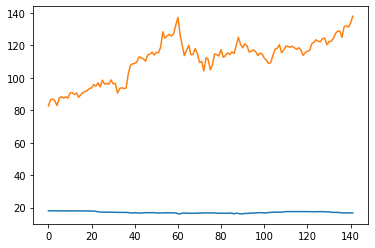







  5%|▌         | 251/5000 [28:46<11:29:33,  8.71s/it]





  5%|▌         | 252/5000 [28:54<11:13:56,  8.52s/it]





  5%|▌         | 253/5000 [29:02<11:06:32,  8.42s/it]





  5%|▌         | 254/5000 [29:10<10:57:32,  8.31s/it]





  5%|▌         | 255/5000 [29:18<10:53:48,  8.27s/it]





  5%|▌         | 256/5000 [29:26<10:42:42,  8.13s/it]





  5%|▌         | 257/5000 [29:34<10:43:46,  8.14s/it]





  5%|▌         | 258/5000 [29:43<10:52:55,  8.26s/it]





  5%|▌         | 259/5000 [29:51<10:49:32,  8.22s/it]





  5%|▌         | 260/5000 [29:59<10:55:37,  8.30s/it]





  5%|▌         | 261/5000 [30:08<11:05:42,  8.43s/it]





  5%|▌         | 262/5000 [30:16<11:05:27,  8.43s/it]





  5%|▌         | 263/5000 [30:25<11:09:27,  8.48s/it]





  5%|▌         | 264/5000 [30:34<11:24:26,  8.67s/it]





  5%|▌         | 265/5000 [30:43<11:28:42,  8.73s/it]





  5%|▌         | 266/5000 [30:52<11:46:55,  8.96s/it]





  5%|▌         | 267/5000 [31:02<12:00:16,  9.13s/

MAE
91.52471838587441



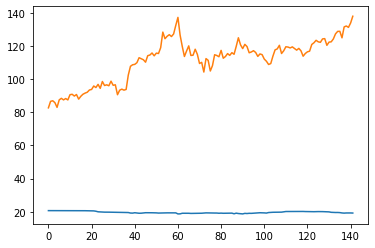







  6%|▌         | 301/5000 [36:22<13:22:31, 10.25s/it]





  6%|▌         | 302/5000 [36:31<12:50:25,  9.84s/it]





  6%|▌         | 303/5000 [36:40<12:27:11,  9.54s/it]





  6%|▌         | 304/5000 [36:49<12:12:29,  9.36s/it]





  6%|▌         | 305/5000 [36:58<12:05:16,  9.27s/it]





  6%|▌         | 306/5000 [37:07<12:01:39,  9.22s/it]





  6%|▌         | 307/5000 [37:17<12:07:29,  9.30s/it]





  6%|▌         | 308/5000 [37:26<12:15:06,  9.40s/it]





  6%|▌         | 309/5000 [37:36<12:10:42,  9.35s/it]





  6%|▌         | 310/5000 [37:45<12:11:45,  9.36s/it]





  6%|▌         | 311/5000 [37:55<12:23:49,  9.52s/it]





  6%|▌         | 312/5000 [38:05<12:35:16,  9.67s/it]





  6%|▋         | 313/5000 [38:15<12:48:08,  9.83s/it]





  6%|▋         | 314/5000 [38:26<13:03:31, 10.03s/it]





  6%|▋         | 315/5000 [38:37<13:36:32, 10.46s/it]





  6%|▋         | 316/5000 [38:49<14:07:38, 10.86s/it]





  6%|▋         | 317/5000 [39:00<14:24:44, 11.08s/

MAE
89.03048404558278



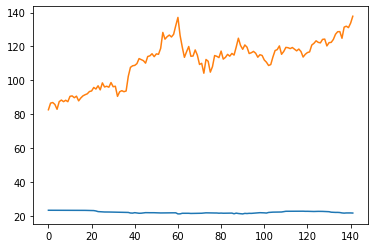







  7%|▋         | 351/5000 [47:12<23:32:57, 18.24s/it]





  7%|▋         | 352/5000 [47:28<22:40:28, 17.56s/it]





  7%|▋         | 353/5000 [47:45<22:10:58, 17.18s/it]





  7%|▋         | 354/5000 [48:01<21:40:51, 16.80s/it]





  7%|▋         | 355/5000 [48:17<21:21:58, 16.56s/it]





  7%|▋         | 356/5000 [48:33<21:15:17, 16.48s/it]





  7%|▋         | 357/5000 [48:48<20:47:39, 16.12s/it]





  7%|▋         | 358/5000 [49:05<20:59:27, 16.28s/it]





  7%|▋         | 359/5000 [49:22<21:14:06, 16.47s/it]





  7%|▋         | 360/5000 [49:39<21:33:07, 16.72s/it]





  7%|▋         | 361/5000 [49:55<21:24:14, 16.61s/it]





  7%|▋         | 362/5000 [50:11<21:03:32, 16.35s/it]





  7%|▋         | 363/5000 [50:28<21:09:23, 16.43s/it]





  7%|▋         | 364/5000 [50:43<20:44:02, 16.10s/it]





  7%|▋         | 365/5000 [50:57<19:53:54, 15.46s/it]





  7%|▋         | 366/5000 [51:10<18:51:41, 14.65s/it]





  7%|▋         | 367/5000 [51:23<18:18:35, 14.23s/

MAE
86.5416697722321



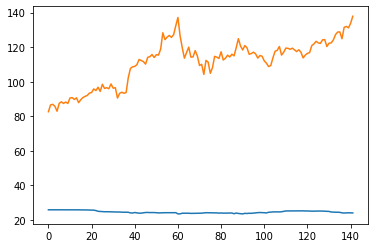







  8%|▊         | 401/5000 [1:00:44<23:33:33, 18.44s/it]





  8%|▊         | 402/5000 [1:01:02<23:11:11, 18.15s/it]





  8%|▊         | 403/5000 [1:01:20<23:08:06, 18.12s/it]





  8%|▊         | 404/5000 [1:01:36<22:31:52, 17.65s/it]





  8%|▊         | 405/5000 [1:01:54<22:33:47, 17.68s/it]





  8%|▊         | 406/5000 [1:02:11<22:26:50, 17.59s/it]





  8%|▊         | 407/5000 [1:02:29<22:31:06, 17.65s/it]





  8%|▊         | 408/5000 [1:02:47<22:35:17, 17.71s/it]





  8%|▊         | 409/5000 [1:03:06<23:00:57, 18.05s/it]





  8%|▊         | 410/5000 [1:03:22<22:30:44, 17.66s/it]





  8%|▊         | 411/5000 [1:03:38<21:46:39, 17.08s/it]





  8%|▊         | 412/5000 [1:03:54<21:23:03, 16.78s/it]





  8%|▊         | 413/5000 [1:04:11<21:10:32, 16.62s/it]





  8%|▊         | 414/5000 [1:04:27<20:57:18, 16.45s/it]





  8%|▊         | 415/5000 [1:04:43<20:46:07, 16.31s/it]





  8%|▊         | 416/5000 [1:04:58<20:31:42, 16.12s/it]





  8%|▊         | 4

MAE
83.83823194019226



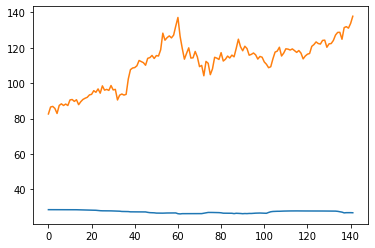







  9%|▉         | 451/5000 [1:14:16<23:11:41, 18.36s/it]





  9%|▉         | 452/5000 [1:14:32<22:20:19, 17.68s/it]





  9%|▉         | 453/5000 [1:14:47<21:35:09, 17.09s/it]





  9%|▉         | 454/5000 [1:15:04<21:19:01, 16.88s/it]





  9%|▉         | 455/5000 [1:15:21<21:36:52, 17.12s/it]





  9%|▉         | 456/5000 [1:15:38<21:33:08, 17.07s/it]





  9%|▉         | 457/5000 [1:15:55<21:12:28, 16.81s/it]





  9%|▉         | 458/5000 [1:16:10<20:46:27, 16.47s/it]





  9%|▉         | 459/5000 [1:16:26<20:31:43, 16.27s/it]





  9%|▉         | 460/5000 [1:16:43<20:44:27, 16.45s/it]





  9%|▉         | 461/5000 [1:17:00<20:51:08, 16.54s/it]





  9%|▉         | 462/5000 [1:17:16<20:49:27, 16.52s/it]





  9%|▉         | 463/5000 [1:17:34<21:17:53, 16.90s/it]





  9%|▉         | 464/5000 [1:17:51<21:24:59, 17.00s/it]





  9%|▉         | 465/5000 [1:18:08<21:29:28, 17.06s/it]





  9%|▉         | 466/5000 [1:18:25<21:08:20, 16.78s/it]





  9%|▉         | 4

MAE
81.25150349495111



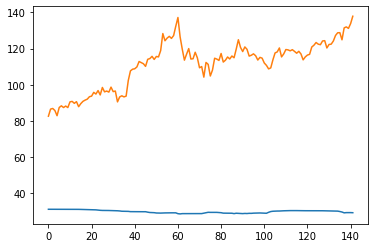







 10%|█         | 501/5000 [1:29:01<26:54:08, 21.53s/it]





 10%|█         | 502/5000 [1:29:20<25:40:45, 20.55s/it]





 10%|█         | 503/5000 [1:29:38<24:49:13, 19.87s/it]





 10%|█         | 504/5000 [1:29:55<23:58:15, 19.19s/it]





 10%|█         | 505/5000 [1:30:14<23:39:44, 18.95s/it]





 10%|█         | 506/5000 [1:30:32<23:12:26, 18.59s/it]





 10%|█         | 507/5000 [1:30:49<22:52:58, 18.33s/it]





 10%|█         | 508/5000 [1:31:07<22:29:11, 18.02s/it]





 10%|█         | 509/5000 [1:31:24<22:06:51, 17.73s/it]





 10%|█         | 510/5000 [1:31:41<21:58:49, 17.62s/it]





 10%|█         | 511/5000 [1:31:58<21:50:18, 17.51s/it]





 10%|█         | 512/5000 [1:32:16<21:43:38, 17.43s/it]





 10%|█         | 513/5000 [1:32:33<21:33:13, 17.29s/it]





 10%|█         | 514/5000 [1:32:49<21:17:59, 17.09s/it]





 10%|█         | 515/5000 [1:33:07<21:29:05, 17.25s/it]





 10%|█         | 516/5000 [1:33:24<21:29:49, 17.26s/it]





 10%|█         | 5

MAE
78.69236551928522



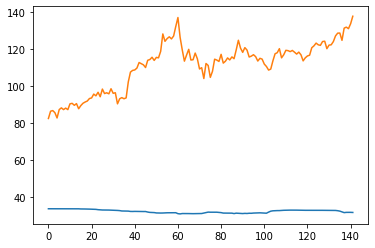







 11%|█         | 551/5000 [1:43:51<29:14:20, 23.66s/it]





 11%|█         | 552/5000 [1:44:11<27:46:40, 22.48s/it]





 11%|█         | 553/5000 [1:44:29<26:09:42, 21.18s/it]





 11%|█         | 554/5000 [1:44:47<24:49:25, 20.10s/it]





 11%|█         | 555/5000 [1:45:06<24:25:07, 19.78s/it]





 11%|█         | 556/5000 [1:45:26<24:47:43, 20.09s/it]





 11%|█         | 557/5000 [1:45:46<24:37:53, 19.96s/it]





 11%|█         | 558/5000 [1:46:05<24:03:54, 19.50s/it]





 11%|█         | 559/5000 [1:46:24<23:56:03, 19.40s/it]





 11%|█         | 560/5000 [1:46:43<23:59:20, 19.45s/it]





 11%|█         | 561/5000 [1:47:02<23:42:21, 19.23s/it]





 11%|█         | 562/5000 [1:47:21<23:33:39, 19.11s/it]





 11%|█▏        | 563/5000 [1:47:40<23:34:20, 19.13s/it]





 11%|█▏        | 564/5000 [1:47:59<23:25:13, 19.01s/it]





 11%|█▏        | 565/5000 [1:48:17<23:01:46, 18.69s/it]





 11%|█▏        | 566/5000 [1:48:34<22:30:27, 18.27s/it]





 11%|█▏        | 5

MAE
76.1138787006224



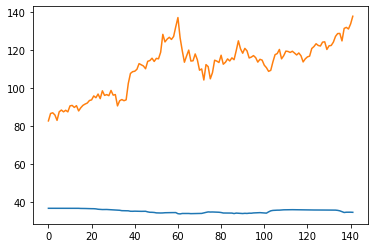







 12%|█▏        | 601/5000 [1:59:30<26:41:17, 21.84s/it]





 12%|█▏        | 602/5000 [1:59:48<25:20:28, 20.74s/it]





 12%|█▏        | 603/5000 [2:00:06<24:17:33, 19.89s/it]





 12%|█▏        | 604/5000 [2:00:24<23:23:10, 19.15s/it]





 12%|█▏        | 605/5000 [2:00:42<23:07:40, 18.94s/it]





 12%|█▏        | 606/5000 [2:01:03<23:51:13, 19.54s/it]





 12%|█▏        | 607/5000 [2:01:22<23:35:15, 19.33s/it]





 12%|█▏        | 608/5000 [2:01:39<22:54:13, 18.77s/it]





 12%|█▏        | 609/5000 [2:01:58<22:56:18, 18.81s/it]





 12%|█▏        | 610/5000 [2:02:17<23:02:53, 18.90s/it]





 12%|█▏        | 611/5000 [2:02:36<22:53:10, 18.77s/it]





 12%|█▏        | 612/5000 [2:02:54<22:51:13, 18.75s/it]





 12%|█▏        | 613/5000 [2:03:12<22:25:10, 18.40s/it]





 12%|█▏        | 614/5000 [2:03:31<22:48:06, 18.72s/it]





 12%|█▏        | 615/5000 [2:03:51<23:06:39, 18.97s/it]





 12%|█▏        | 616/5000 [2:04:09<22:54:49, 18.82s/it]





 12%|█▏        | 6

MAE
73.5480963954019



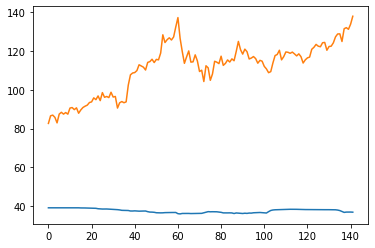







 13%|█▎        | 651/5000 [2:14:35<22:28:53, 18.61s/it]





 13%|█▎        | 652/5000 [2:14:51<21:26:48, 17.76s/it]





 13%|█▎        | 653/5000 [2:15:06<20:41:04, 17.13s/it]





 13%|█▎        | 654/5000 [2:15:22<20:07:45, 16.67s/it]





 13%|█▎        | 655/5000 [2:15:38<19:43:33, 16.34s/it]





 13%|█▎        | 656/5000 [2:15:53<19:23:31, 16.07s/it]





 13%|█▎        | 657/5000 [2:16:09<19:19:31, 16.02s/it]





 13%|█▎        | 658/5000 [2:16:25<19:10:25, 15.90s/it]





 13%|█▎        | 659/5000 [2:16:40<19:03:25, 15.80s/it]





 13%|█▎        | 660/5000 [2:16:56<19:06:07, 15.85s/it]





 13%|█▎        | 661/5000 [2:17:12<19:02:12, 15.79s/it]





 13%|█▎        | 662/5000 [2:17:27<18:59:27, 15.76s/it]





 13%|█▎        | 663/5000 [2:17:43<18:56:21, 15.72s/it]





 13%|█▎        | 664/5000 [2:17:59<18:51:47, 15.66s/it]





 13%|█▎        | 665/5000 [2:18:14<18:54:48, 15.71s/it]





 13%|█▎        | 666/5000 [2:18:30<18:43:57, 15.56s/it]





 13%|█▎        | 6

MAE
70.99639123646979



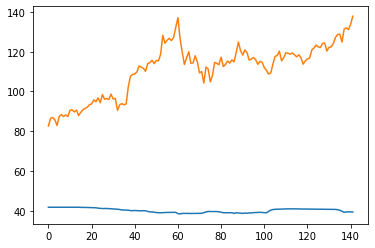







 14%|█▍        | 701/5000 [2:27:42<21:34:57, 18.07s/it]





 14%|█▍        | 702/5000 [2:27:58<20:36:10, 17.26s/it]





 14%|█▍        | 703/5000 [2:28:13<19:52:54, 16.66s/it]





 14%|█▍        | 704/5000 [2:28:28<19:24:31, 16.26s/it]





 14%|█▍        | 705/5000 [2:28:44<19:14:52, 16.13s/it]





 14%|█▍        | 706/5000 [2:28:59<18:58:42, 15.91s/it]





 14%|█▍        | 707/5000 [2:29:15<18:48:28, 15.77s/it]





 14%|█▍        | 708/5000 [2:29:31<18:56:41, 15.89s/it]





 14%|█▍        | 709/5000 [2:29:48<19:24:16, 16.28s/it]





 14%|█▍        | 710/5000 [2:30:05<19:39:45, 16.50s/it]





 14%|█▍        | 711/5000 [2:30:22<19:39:58, 16.51s/it]





 14%|█▍        | 712/5000 [2:30:39<19:48:34, 16.63s/it]





 14%|█▍        | 713/5000 [2:30:56<20:02:22, 16.83s/it]





 14%|█▍        | 714/5000 [2:31:13<19:59:47, 16.80s/it]





 14%|█▍        | 715/5000 [2:31:29<19:43:12, 16.57s/it]





 14%|█▍        | 716/5000 [2:31:45<19:37:47, 16.50s/it]





 14%|█▍        | 7

MAE
68.46389565722038



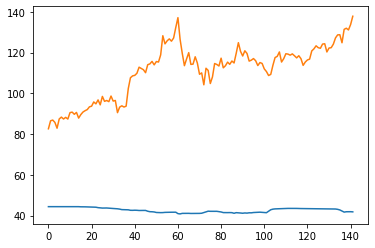







 15%|█▌        | 751/5000 [2:41:36<22:39:58, 19.20s/it]





 15%|█▌        | 752/5000 [2:41:52<21:34:39, 18.29s/it]





 15%|█▌        | 753/5000 [2:42:08<20:42:21, 17.55s/it]





 15%|█▌        | 754/5000 [2:42:24<20:17:07, 17.20s/it]





 15%|█▌        | 755/5000 [2:42:41<20:12:09, 17.13s/it]





 15%|█▌        | 756/5000 [2:42:58<20:09:54, 17.11s/it]





 15%|█▌        | 757/5000 [2:43:14<19:51:23, 16.85s/it]





 15%|█▌        | 758/5000 [2:43:32<19:56:10, 16.92s/it]





 15%|█▌        | 759/5000 [2:43:47<19:33:25, 16.60s/it]





 15%|█▌        | 760/5000 [2:44:04<19:39:02, 16.68s/it]





 15%|█▌        | 761/5000 [2:44:21<19:37:40, 16.67s/it]





 15%|█▌        | 762/5000 [2:44:37<19:30:24, 16.57s/it]





 15%|█▌        | 763/5000 [2:44:54<19:23:47, 16.48s/it]





 15%|█▌        | 764/5000 [2:45:10<19:27:36, 16.54s/it]





 15%|█▌        | 765/5000 [2:45:27<19:32:30, 16.61s/it]





 15%|█▌        | 766/5000 [2:45:43<19:27:54, 16.55s/it]





 15%|█▌        | 7

MAE
65.92302198194116



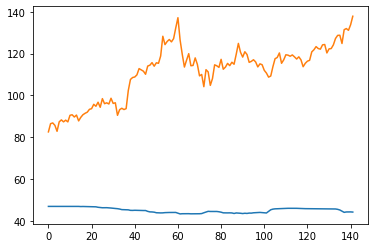







 16%|█▌        | 801/5000 [2:55:40<22:30:40, 19.30s/it]





 16%|█▌        | 802/5000 [2:55:56<21:20:35, 18.30s/it]





 16%|█▌        | 803/5000 [2:56:11<20:16:45, 17.39s/it]





 16%|█▌        | 804/5000 [2:56:28<19:56:39, 17.11s/it]





 16%|█▌        | 805/5000 [2:56:44<19:44:30, 16.94s/it]





 16%|█▌        | 806/5000 [2:57:00<19:23:01, 16.64s/it]





 16%|█▌        | 807/5000 [2:57:17<19:18:55, 16.58s/it]





 16%|█▌        | 808/5000 [2:57:33<19:22:18, 16.64s/it]





 16%|█▌        | 809/5000 [2:57:50<19:24:31, 16.67s/it]





 16%|█▌        | 810/5000 [2:58:07<19:27:19, 16.72s/it]





 16%|█▌        | 811/5000 [2:58:23<19:22:08, 16.65s/it]





 16%|█▌        | 812/5000 [2:58:41<19:40:03, 16.91s/it]





 16%|█▋        | 813/5000 [2:58:58<19:34:01, 16.82s/it]





 16%|█▋        | 814/5000 [2:59:15<19:46:08, 17.00s/it]





 16%|█▋        | 815/5000 [2:59:31<19:34:44, 16.84s/it]





 16%|█▋        | 816/5000 [2:59:48<19:22:18, 16.67s/it]





 16%|█▋        | 8

MAE
63.400708125198406



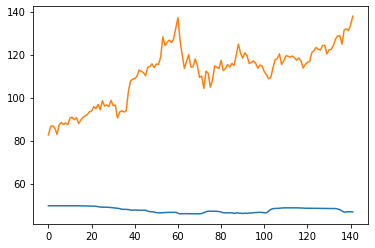







 17%|█▋        | 851/5000 [3:09:51<23:10:57, 20.12s/it]





 17%|█▋        | 852/5000 [3:10:08<22:12:26, 19.27s/it]





 17%|█▋        | 853/5000 [3:10:25<21:23:05, 18.56s/it]





 17%|█▋        | 854/5000 [3:10:41<20:26:30, 17.75s/it]





 17%|█▋        | 855/5000 [3:10:58<20:04:28, 17.43s/it]





 17%|█▋        | 856/5000 [3:11:15<19:57:26, 17.34s/it]





 17%|█▋        | 857/5000 [3:11:32<19:44:55, 17.16s/it]





 17%|█▋        | 858/5000 [3:11:48<19:32:33, 16.99s/it]





 17%|█▋        | 859/5000 [3:12:05<19:32:12, 16.98s/it]





 17%|█▋        | 860/5000 [3:12:22<19:34:05, 17.02s/it]





 17%|█▋        | 861/5000 [3:12:40<19:55:26, 17.33s/it]





 17%|█▋        | 862/5000 [3:12:59<20:23:26, 17.74s/it]





 17%|█▋        | 863/5000 [3:13:17<20:26:39, 17.79s/it]





 17%|█▋        | 864/5000 [3:13:34<20:19:25, 17.69s/it]





 17%|█▋        | 865/5000 [3:13:52<20:23:01, 17.75s/it]





 17%|█▋        | 866/5000 [3:14:09<19:51:01, 17.29s/it]





 17%|█▋        | 8

MAE
60.88035698392695



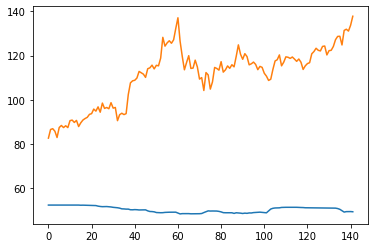







 18%|█▊        | 901/5000 [3:24:55<24:19:25, 21.36s/it]





 18%|█▊        | 902/5000 [3:25:13<23:20:19, 20.50s/it]





 18%|█▊        | 903/5000 [3:25:31<22:30:33, 19.78s/it]





 18%|█▊        | 904/5000 [3:25:49<21:41:03, 19.06s/it]





 18%|█▊        | 905/5000 [3:26:07<21:18:43, 18.74s/it]





 18%|█▊        | 906/5000 [3:26:25<21:14:14, 18.67s/it]





 18%|█▊        | 907/5000 [3:26:43<21:02:48, 18.51s/it]





 18%|█▊        | 908/5000 [3:27:01<20:55:30, 18.41s/it]





 18%|█▊        | 909/5000 [3:27:20<20:51:13, 18.35s/it]





 18%|█▊        | 910/5000 [3:27:38<20:58:40, 18.46s/it]





 18%|█▊        | 911/5000 [3:27:57<20:57:09, 18.45s/it]





 18%|█▊        | 912/5000 [3:28:15<21:01:56, 18.52s/it]





 18%|█▊        | 913/5000 [3:28:33<20:41:30, 18.23s/it]





 18%|█▊        | 914/5000 [3:28:51<20:35:14, 18.14s/it]





 18%|█▊        | 915/5000 [3:29:09<20:26:32, 18.02s/it]





 18%|█▊        | 916/5000 [3:29:28<21:03:25, 18.56s/it]





 18%|█▊        | 9

MAE
58.3611644629257



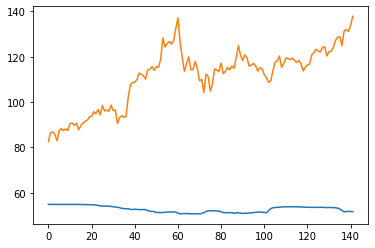







 19%|█▉        | 951/5000 [3:39:54<23:03:34, 20.50s/it]





 19%|█▉        | 952/5000 [3:40:10<21:27:03, 19.08s/it]





 19%|█▉        | 953/5000 [3:40:27<20:50:31, 18.54s/it]





 19%|█▉        | 954/5000 [3:40:45<20:35:01, 18.31s/it]





 19%|█▉        | 955/5000 [3:41:03<20:28:44, 18.23s/it]





 19%|█▉        | 956/5000 [3:41:20<20:09:19, 17.94s/it]





 19%|█▉        | 957/5000 [3:41:38<20:01:11, 17.83s/it]





 19%|█▉        | 958/5000 [3:41:55<19:54:45, 17.74s/it]





 19%|█▉        | 959/5000 [3:42:13<19:52:03, 17.70s/it]





 19%|█▉        | 960/5000 [3:42:31<19:55:44, 17.76s/it]





 19%|█▉        | 961/5000 [3:42:48<19:44:13, 17.59s/it]





 19%|█▉        | 962/5000 [3:43:05<19:41:36, 17.56s/it]





 19%|█▉        | 963/5000 [3:43:23<19:40:57, 17.55s/it]





 19%|█▉        | 964/5000 [3:43:42<20:10:51, 18.00s/it]





 19%|█▉        | 965/5000 [3:44:01<20:25:29, 18.22s/it]





 19%|█▉        | 966/5000 [3:44:19<20:30:38, 18.30s/it]





 19%|█▉        | 9

MAE
55.848512616483276



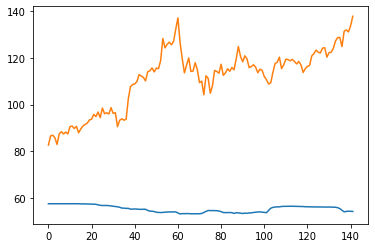







 20%|██        | 1001/5000 [3:54:47<24:27:40, 22.02s/it]





 20%|██        | 1002/5000 [3:55:06<23:23:25, 21.06s/it]





 20%|██        | 1003/5000 [3:55:24<22:29:37, 20.26s/it]





 20%|██        | 1004/5000 [3:55:42<21:42:55, 19.56s/it]





 20%|██        | 1005/5000 [3:56:01<21:18:58, 19.21s/it]





 20%|██        | 1006/5000 [3:56:18<20:47:41, 18.74s/it]





 20%|██        | 1007/5000 [3:56:37<20:56:50, 18.89s/it]





 20%|██        | 1008/5000 [3:56:55<20:25:52, 18.42s/it]





 20%|██        | 1009/5000 [3:57:12<20:05:04, 18.12s/it]





 20%|██        | 1010/5000 [3:57:29<19:45:09, 17.82s/it]





 20%|██        | 1011/5000 [3:57:46<19:26:54, 17.55s/it]





 20%|██        | 1012/5000 [3:58:04<19:29:03, 17.59s/it]





 20%|██        | 1013/5000 [3:58:21<19:22:30, 17.49s/it]





 20%|██        | 1014/5000 [3:58:38<19:10:36, 17.32s/it]





 20%|██        | 1015/5000 [3:58:55<18:54:09, 17.08s/it]





 20%|██        | 1016/5000 [3:59:12<18:51:40, 17.04s/it]





 2

MAE
53.35083445077885



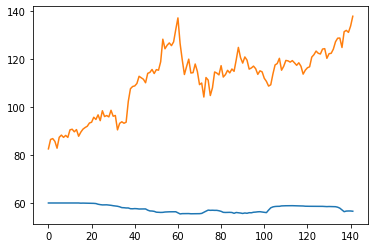







 21%|██        | 1051/5000 [4:09:20<21:51:11, 19.92s/it]





 21%|██        | 1052/5000 [4:09:37<20:53:00, 19.04s/it]





 21%|██        | 1053/5000 [4:09:55<20:23:30, 18.60s/it]





 21%|██        | 1054/5000 [4:10:12<19:50:52, 18.11s/it]





 21%|██        | 1055/5000 [4:10:29<19:29:36, 17.79s/it]





 21%|██        | 1056/5000 [4:10:46<19:13:17, 17.54s/it]





 21%|██        | 1057/5000 [4:11:03<19:06:02, 17.44s/it]





 21%|██        | 1058/5000 [4:11:21<19:15:31, 17.59s/it]





 21%|██        | 1059/5000 [4:11:38<18:59:08, 17.34s/it]





 21%|██        | 1060/5000 [4:11:54<18:35:09, 16.98s/it]





 21%|██        | 1061/5000 [4:12:11<18:42:18, 17.10s/it]





 21%|██        | 1062/5000 [4:12:29<18:50:40, 17.23s/it]





 21%|██▏       | 1063/5000 [4:12:47<19:01:25, 17.40s/it]





 21%|██▏       | 1064/5000 [4:13:04<18:50:29, 17.23s/it]





 21%|██▏       | 1065/5000 [4:13:21<19:00:37, 17.39s/it]





 21%|██▏       | 1066/5000 [4:13:39<19:04:57, 17.46s/it]





 2

MAE
50.87927476505832



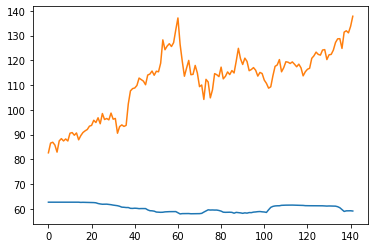







 22%|██▏       | 1101/5000 [4:24:05<22:31:55, 20.80s/it]





 22%|██▏       | 1102/5000 [4:24:22<21:13:41, 19.61s/it]





 22%|██▏       | 1103/5000 [4:24:39<20:28:17, 18.91s/it]





 22%|██▏       | 1104/5000 [4:24:56<19:55:39, 18.41s/it]





 22%|██▏       | 1105/5000 [4:25:14<19:43:32, 18.23s/it]





 22%|██▏       | 1106/5000 [4:25:31<19:21:12, 17.89s/it]





 22%|██▏       | 1107/5000 [4:25:47<18:44:43, 17.33s/it]





 22%|██▏       | 1108/5000 [4:26:04<18:21:09, 16.98s/it]





 22%|██▏       | 1109/5000 [4:26:20<18:16:32, 16.91s/it]





 22%|██▏       | 1110/5000 [4:26:38<18:25:04, 17.04s/it]





 22%|██▏       | 1111/5000 [4:26:54<18:12:45, 16.86s/it]





 22%|██▏       | 1112/5000 [4:27:10<17:58:19, 16.64s/it]





 22%|██▏       | 1113/5000 [4:27:27<18:00:12, 16.67s/it]





 22%|██▏       | 1114/5000 [4:27:44<18:03:01, 16.72s/it]





 22%|██▏       | 1115/5000 [4:28:01<18:13:52, 16.89s/it]





 22%|██▏       | 1116/5000 [4:28:18<18:10:46, 16.85s/it]





 2

MAE
48.12929805620289



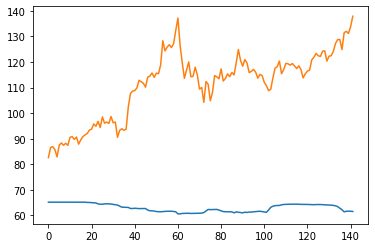







 23%|██▎       | 1151/5000 [4:38:12<20:57:44, 19.61s/it]





 23%|██▎       | 1152/5000 [4:38:29<20:17:09, 18.98s/it]





 23%|██▎       | 1153/5000 [4:38:45<19:22:10, 18.13s/it]





 23%|██▎       | 1154/5000 [4:39:01<18:46:16, 17.57s/it]





 23%|██▎       | 1155/5000 [4:39:18<18:33:04, 17.37s/it]





 23%|██▎       | 1156/5000 [4:39:35<18:16:35, 17.12s/it]





 23%|██▎       | 1157/5000 [4:39:51<17:59:40, 16.86s/it]





 23%|██▎       | 1158/5000 [4:40:08<17:56:22, 16.81s/it]





 23%|██▎       | 1159/5000 [4:40:24<17:51:40, 16.74s/it]





 23%|██▎       | 1160/5000 [4:40:41<17:48:31, 16.70s/it]





 23%|██▎       | 1161/5000 [4:40:58<17:44:56, 16.64s/it]





 23%|██▎       | 1162/5000 [4:41:14<17:42:25, 16.61s/it]





 23%|██▎       | 1163/5000 [4:41:30<17:32:25, 16.46s/it]





 23%|██▎       | 1164/5000 [4:41:47<17:35:01, 16.50s/it]





 23%|██▎       | 1165/5000 [4:42:03<17:34:29, 16.50s/it]





 23%|██▎       | 1166/5000 [4:42:18<17:05:08, 16.04s/it]





 2

MAE
45.71404502142317



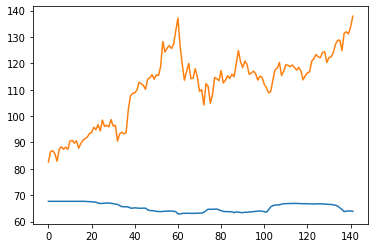







 24%|██▍       | 1201/5000 [4:52:18<21:04:58, 19.98s/it]





 24%|██▍       | 1202/5000 [4:52:34<20:00:08, 18.96s/it]





 24%|██▍       | 1203/5000 [4:52:51<19:16:07, 18.27s/it]





 24%|██▍       | 1204/5000 [4:53:08<18:47:57, 17.83s/it]





 24%|██▍       | 1205/5000 [4:53:25<18:31:06, 17.57s/it]





 24%|██▍       | 1206/5000 [4:53:41<18:12:07, 17.27s/it]





 24%|██▍       | 1207/5000 [4:53:57<17:40:52, 16.78s/it]





 24%|██▍       | 1208/5000 [4:54:13<17:35:22, 16.70s/it]





 24%|██▍       | 1209/5000 [4:54:30<17:36:43, 16.72s/it]





 24%|██▍       | 1210/5000 [4:54:47<17:41:36, 16.81s/it]





 24%|██▍       | 1211/5000 [4:55:04<17:37:02, 16.74s/it]





 24%|██▍       | 1212/5000 [4:55:20<17:34:14, 16.70s/it]





 24%|██▍       | 1213/5000 [4:55:37<17:32:25, 16.67s/it]





 24%|██▍       | 1214/5000 [4:55:53<17:28:05, 16.61s/it]





 24%|██▍       | 1215/5000 [4:56:10<17:38:41, 16.78s/it]





 24%|██▍       | 1216/5000 [4:56:27<17:35:34, 16.74s/it]





 2

MAE
43.37018517426036



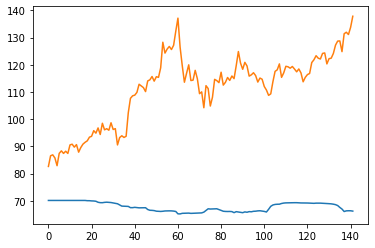







 25%|██▌       | 1251/5000 [5:06:23<20:46:44, 19.95s/it]





 25%|██▌       | 1252/5000 [5:06:40<19:44:11, 18.96s/it]





 25%|██▌       | 1253/5000 [5:06:57<19:02:18, 18.29s/it]





 25%|██▌       | 1254/5000 [5:07:13<18:31:28, 17.80s/it]





 25%|██▌       | 1255/5000 [5:07:30<18:07:02, 17.42s/it]





 25%|██▌       | 1256/5000 [5:07:46<17:51:10, 17.17s/it]





 25%|██▌       | 1257/5000 [5:08:02<17:22:13, 16.71s/it]





 25%|██▌       | 1258/5000 [5:08:18<17:19:19, 16.66s/it]





 25%|██▌       | 1259/5000 [5:08:35<17:22:17, 16.72s/it]





 25%|██▌       | 1260/5000 [5:08:52<17:27:27, 16.80s/it]





 25%|██▌       | 1261/5000 [5:09:09<17:24:57, 16.77s/it]





 25%|██▌       | 1262/5000 [5:09:25<17:16:35, 16.64s/it]





 25%|██▌       | 1263/5000 [5:09:42<17:19:28, 16.69s/it]





 25%|██▌       | 1264/5000 [5:09:59<17:21:16, 16.72s/it]





 25%|██▌       | 1265/5000 [5:10:16<17:29:39, 16.86s/it]





 25%|██▌       | 1266/5000 [5:10:33<17:25:58, 16.81s/it]





 2

MAE
41.152678926753346



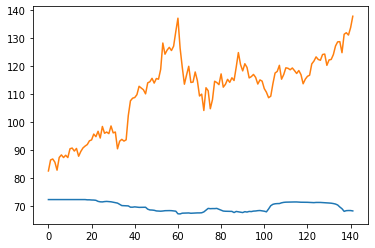







 26%|██▌       | 1301/5000 [5:20:50<21:16:10, 20.70s/it]





 26%|██▌       | 1302/5000 [5:21:08<20:12:40, 19.68s/it]





 26%|██▌       | 1303/5000 [5:21:25<19:28:56, 18.97s/it]





 26%|██▌       | 1304/5000 [5:21:42<18:57:34, 18.47s/it]





 26%|██▌       | 1305/5000 [5:22:00<18:44:46, 18.26s/it]





 26%|██▌       | 1306/5000 [5:22:17<18:24:31, 17.94s/it]





 26%|██▌       | 1307/5000 [5:22:34<18:11:07, 17.73s/it]





 26%|██▌       | 1308/5000 [5:22:51<17:49:06, 17.37s/it]





 26%|██▌       | 1309/5000 [5:23:08<17:40:28, 17.24s/it]





 26%|██▌       | 1310/5000 [5:23:26<17:48:18, 17.37s/it]





 26%|██▌       | 1311/5000 [5:23:42<17:37:53, 17.21s/it]





 26%|██▌       | 1312/5000 [5:24:00<17:40:55, 17.26s/it]





 26%|██▋       | 1313/5000 [5:24:17<17:42:48, 17.30s/it]





 26%|██▋       | 1314/5000 [5:24:34<17:41:24, 17.28s/it]





 26%|██▋       | 1315/5000 [5:24:52<17:40:12, 17.26s/it]





 26%|██▋       | 1316/5000 [5:25:09<17:42:06, 17.30s/it]





 2

MAE
39.36449079834913



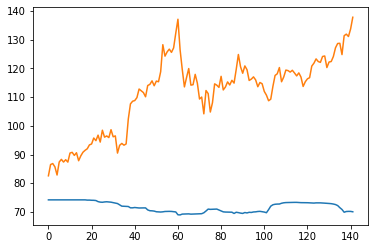







 27%|██▋       | 1351/5000 [5:35:03<20:03:50, 19.79s/it]





 27%|██▋       | 1352/5000 [5:35:19<19:06:45, 18.86s/it]





 27%|██▋       | 1353/5000 [5:35:36<18:21:35, 18.12s/it]





 27%|██▋       | 1354/5000 [5:35:52<17:51:59, 17.64s/it]





 27%|██▋       | 1355/5000 [5:36:10<17:47:12, 17.57s/it]





 27%|██▋       | 1356/5000 [5:36:27<17:36:31, 17.40s/it]





 27%|██▋       | 1357/5000 [5:36:43<17:16:59, 17.08s/it]





 27%|██▋       | 1358/5000 [5:36:59<16:54:21, 16.71s/it]





 27%|██▋       | 1359/5000 [5:37:15<16:48:09, 16.61s/it]





 27%|██▋       | 1360/5000 [5:37:32<16:44:43, 16.56s/it]





 27%|██▋       | 1361/5000 [5:37:48<16:36:07, 16.42s/it]





 27%|██▋       | 1362/5000 [5:38:04<16:40:39, 16.50s/it]





 27%|██▋       | 1363/5000 [5:38:21<16:42:12, 16.53s/it]





 27%|██▋       | 1364/5000 [5:38:38<16:43:26, 16.56s/it]





 27%|██▋       | 1365/5000 [5:38:55<16:50:55, 16.69s/it]





 27%|██▋       | 1366/5000 [5:39:11<16:46:18, 16.61s/it]





 2

MAE
57.9110298363491



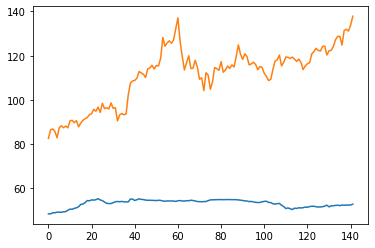







 28%|██▊       | 1401/5000 [5:49:24<20:27:52, 20.47s/it]





 28%|██▊       | 1402/5000 [5:49:42<19:38:32, 19.65s/it]





 28%|██▊       | 1403/5000 [5:50:00<19:15:47, 19.28s/it]





 28%|██▊       | 1404/5000 [5:50:18<18:52:02, 18.89s/it]





 28%|██▊       | 1405/5000 [5:50:36<18:29:33, 18.52s/it]





 28%|██▊       | 1406/5000 [5:50:53<18:11:10, 18.22s/it]





 28%|██▊       | 1407/5000 [5:51:11<17:59:32, 18.03s/it]





 28%|██▊       | 1408/5000 [5:51:28<17:52:52, 17.92s/it]





 28%|██▊       | 1409/5000 [5:51:46<17:41:14, 17.73s/it]





 28%|██▊       | 1410/5000 [5:52:03<17:31:21, 17.57s/it]





 28%|██▊       | 1411/5000 [5:52:20<17:31:43, 17.58s/it]





 28%|██▊       | 1412/5000 [5:52:38<17:33:48, 17.62s/it]





 28%|██▊       | 1413/5000 [5:52:56<17:41:33, 17.76s/it]





 28%|██▊       | 1414/5000 [5:53:14<17:42:57, 17.79s/it]





 28%|██▊       | 1415/5000 [5:53:32<17:38:48, 17.72s/it]





 28%|██▊       | 1416/5000 [5:53:49<17:38:06, 17.71s/it]





 2

MAE
61.77388271196461



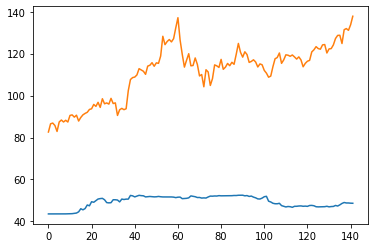







 29%|██▉       | 1451/5000 [6:04:39<20:35:24, 20.89s/it]





 29%|██▉       | 1452/5000 [6:04:57<19:39:23, 19.94s/it]





 29%|██▉       | 1453/5000 [6:05:14<18:52:59, 19.17s/it]





 29%|██▉       | 1454/5000 [6:05:31<18:23:07, 18.67s/it]





 29%|██▉       | 1455/5000 [6:05:49<17:59:16, 18.27s/it]





 29%|██▉       | 1456/5000 [6:06:06<17:41:31, 17.97s/it]





 29%|██▉       | 1457/5000 [6:06:24<17:41:08, 17.97s/it]





 29%|██▉       | 1458/5000 [6:06:41<17:28:00, 17.75s/it]





 29%|██▉       | 1459/5000 [6:06:59<17:21:29, 17.65s/it]





 29%|██▉       | 1460/5000 [6:07:16<17:23:56, 17.69s/it]





 29%|██▉       | 1461/5000 [6:07:34<17:23:38, 17.69s/it]





 29%|██▉       | 1462/5000 [6:07:52<17:28:49, 17.79s/it]





 29%|██▉       | 1463/5000 [6:08:10<17:26:26, 17.75s/it]





 29%|██▉       | 1464/5000 [6:08:27<17:10:59, 17.49s/it]





 29%|██▉       | 1465/5000 [6:08:45<17:18:35, 17.63s/it]





 29%|██▉       | 1466/5000 [6:09:02<17:20:09, 17.66s/it]





 2

MAE
65.18393760384642



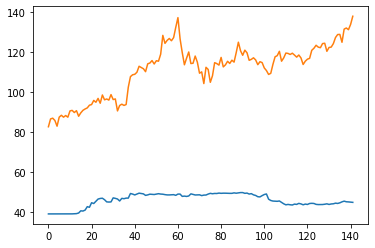







 30%|███       | 1501/5000 [6:19:50<19:59:39, 20.57s/it]





 30%|███       | 1502/5000 [6:20:08<19:09:34, 19.72s/it]





 30%|███       | 1503/5000 [6:20:25<18:25:20, 18.96s/it]





 30%|███       | 1504/5000 [6:20:42<17:59:31, 18.53s/it]





 30%|███       | 1505/5000 [6:21:00<17:43:17, 18.25s/it]





 30%|███       | 1506/5000 [6:21:17<17:29:40, 18.03s/it]





 30%|███       | 1507/5000 [6:21:35<17:22:58, 17.92s/it]





 30%|███       | 1508/5000 [6:21:53<17:21:01, 17.89s/it]





 30%|███       | 1509/5000 [6:22:10<17:14:03, 17.77s/it]





 30%|███       | 1510/5000 [6:22:28<17:15:11, 17.80s/it]





 30%|███       | 1511/5000 [6:22:46<17:08:32, 17.69s/it]





 30%|███       | 1512/5000 [6:23:03<17:04:42, 17.63s/it]





 30%|███       | 1513/5000 [6:23:21<17:09:15, 17.71s/it]





 30%|███       | 1514/5000 [6:23:38<17:03:20, 17.61s/it]





 30%|███       | 1515/5000 [6:23:56<17:07:35, 17.69s/it]





 30%|███       | 1516/5000 [6:24:14<16:59:56, 17.56s/it]





 3

MAE
67.49797815053229



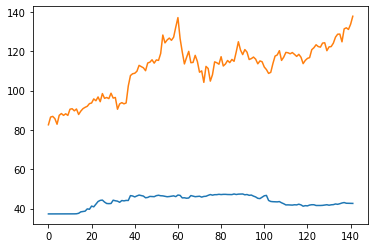







 31%|███       | 1551/5000 [6:34:18<18:40:19, 19.49s/it]





 31%|███       | 1552/5000 [6:34:35<17:45:45, 18.55s/it]





 31%|███       | 1553/5000 [6:34:51<17:08:58, 17.91s/it]





 31%|███       | 1554/5000 [6:35:08<16:51:50, 17.62s/it]





 31%|███       | 1555/5000 [6:35:25<16:43:05, 17.47s/it]





 31%|███       | 1556/5000 [6:35:41<16:22:59, 17.13s/it]





 31%|███       | 1557/5000 [6:35:58<16:18:49, 17.06s/it]





 31%|███       | 1558/5000 [6:36:15<16:18:21, 17.05s/it]





 31%|███       | 1559/5000 [6:36:33<16:21:18, 17.11s/it]





 31%|███       | 1560/5000 [6:36:50<16:23:13, 17.15s/it]





 31%|███       | 1561/5000 [6:37:07<16:17:46, 17.06s/it]





 31%|███       | 1562/5000 [6:37:23<16:13:16, 16.99s/it]





 31%|███▏      | 1563/5000 [6:37:40<16:11:02, 16.95s/it]





 31%|███▏      | 1564/5000 [6:37:57<16:11:14, 16.96s/it]





 31%|███▏      | 1565/5000 [6:38:15<16:15:38, 17.04s/it]





 31%|███▏      | 1566/5000 [6:38:31<16:10:22, 16.95s/it]





 3

MAE
70.14896762927486



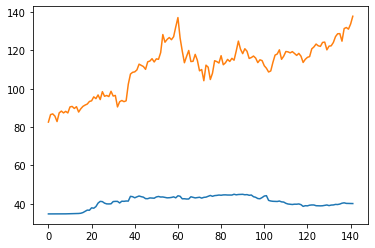







 32%|███▏      | 1601/5000 [6:48:32<18:19:29, 19.41s/it]





 32%|███▏      | 1602/5000 [6:48:48<17:35:15, 18.63s/it]





 32%|███▏      | 1603/5000 [6:49:05<17:07:37, 18.15s/it]





 32%|███▏      | 1604/5000 [6:49:23<16:51:24, 17.87s/it]





 32%|███▏      | 1605/5000 [6:49:40<16:40:58, 17.69s/it]





 32%|███▏      | 1606/5000 [6:49:57<16:25:17, 17.42s/it]





 32%|███▏      | 1607/5000 [6:50:14<16:16:14, 17.26s/it]





 32%|███▏      | 1608/5000 [6:50:30<16:10:29, 17.17s/it]





 32%|███▏      | 1609/5000 [6:50:47<16:04:33, 17.07s/it]





 32%|███▏      | 1610/5000 [6:51:04<16:03:42, 17.06s/it]





 32%|███▏      | 1611/5000 [6:51:21<15:54:03, 16.89s/it]





 32%|███▏      | 1612/5000 [6:51:37<15:47:43, 16.78s/it]





 32%|███▏      | 1613/5000 [6:51:54<15:46:11, 16.76s/it]





 32%|███▏      | 1614/5000 [6:52:11<15:46:24, 16.77s/it]





 32%|███▏      | 1615/5000 [6:52:28<15:49:15, 16.83s/it]





 32%|███▏      | 1616/5000 [6:52:45<15:50:04, 16.85s/it]





 3

MAE
50.18663521268672



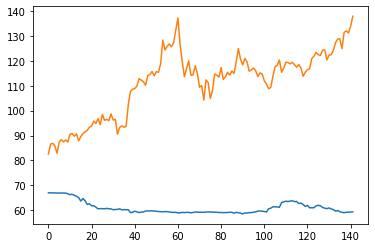







 33%|███▎      | 1651/5000 [7:02:47<18:41:47, 20.10s/it]





 33%|███▎      | 1652/5000 [7:03:04<17:59:45, 19.35s/it]





 33%|███▎      | 1653/5000 [7:03:22<17:31:49, 18.86s/it]





 33%|███▎      | 1654/5000 [7:03:39<17:04:08, 18.36s/it]





 33%|███▎      | 1655/5000 [7:03:57<16:49:51, 18.11s/it]





 33%|███▎      | 1656/5000 [7:04:14<16:29:41, 17.76s/it]





 33%|███▎      | 1657/5000 [7:04:31<16:19:57, 17.59s/it]





 33%|███▎      | 1658/5000 [7:04:48<16:17:20, 17.55s/it]





 33%|███▎      | 1659/5000 [7:05:05<16:09:04, 17.40s/it]





 33%|███▎      | 1660/5000 [7:05:23<16:08:22, 17.40s/it]





 33%|███▎      | 1661/5000 [7:05:40<16:00:15, 17.26s/it]





 33%|███▎      | 1662/5000 [7:05:57<15:55:12, 17.17s/it]





 33%|███▎      | 1663/5000 [7:06:14<15:58:17, 17.23s/it]





 33%|███▎      | 1664/5000 [7:06:31<15:59:11, 17.25s/it]





 33%|███▎      | 1665/5000 [7:06:49<16:01:26, 17.30s/it]





 33%|███▎      | 1666/5000 [7:07:06<15:55:13, 17.19s/it]





 3

MAE
47.53285560526312



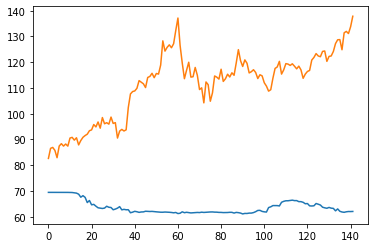







 34%|███▍      | 1701/5000 [7:16:58<17:31:25, 19.12s/it]





 34%|███▍      | 1702/5000 [7:17:14<16:48:30, 18.35s/it]





 34%|███▍      | 1703/5000 [7:17:31<16:23:32, 17.90s/it]





 34%|███▍      | 1704/5000 [7:17:47<16:00:08, 17.48s/it]





 34%|███▍      | 1705/5000 [7:18:04<15:47:36, 17.26s/it]





 34%|███▍      | 1706/5000 [7:18:20<15:28:49, 16.92s/it]





 34%|███▍      | 1707/5000 [7:18:37<15:17:26, 16.72s/it]





 34%|███▍      | 1708/5000 [7:18:53<15:13:47, 16.65s/it]





 34%|███▍      | 1709/5000 [7:19:10<15:11:12, 16.61s/it]





 34%|███▍      | 1710/5000 [7:19:26<15:13:59, 16.67s/it]





 34%|███▍      | 1711/5000 [7:19:43<15:08:29, 16.57s/it]





 34%|███▍      | 1712/5000 [7:20:00<15:13:12, 16.66s/it]





 34%|███▍      | 1713/5000 [7:20:16<15:11:25, 16.64s/it]





 34%|███▍      | 1714/5000 [7:20:32<15:06:38, 16.55s/it]





 34%|███▍      | 1715/5000 [7:20:49<15:01:42, 16.47s/it]





 34%|███▍      | 1716/5000 [7:21:05<14:58:08, 16.41s/it]





 3

MAE
45.06338237089844



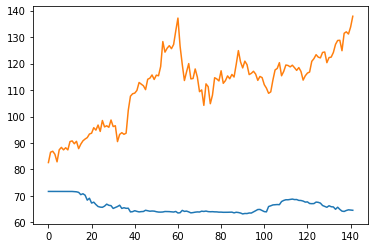







 35%|███▌      | 1751/5000 [7:30:51<17:30:57, 19.41s/it]





 35%|███▌      | 1752/5000 [7:31:08<16:46:06, 18.59s/it]





 35%|███▌      | 1753/5000 [7:31:25<16:21:05, 18.13s/it]





 35%|███▌      | 1754/5000 [7:31:42<15:54:39, 17.65s/it]





 35%|███▌      | 1755/5000 [7:31:58<15:40:00, 17.38s/it]





 35%|███▌      | 1756/5000 [7:32:15<15:30:34, 17.21s/it]





 35%|███▌      | 1757/5000 [7:32:32<15:22:00, 17.06s/it]





 35%|███▌      | 1758/5000 [7:32:48<15:14:23, 16.92s/it]





 35%|███▌      | 1759/5000 [7:33:05<15:09:10, 16.83s/it]





 35%|███▌      | 1760/5000 [7:33:22<15:11:00, 16.87s/it]





 35%|███▌      | 1761/5000 [7:33:38<15:02:33, 16.72s/it]





 35%|███▌      | 1762/5000 [7:33:55<14:59:13, 16.66s/it]





 35%|███▌      | 1763/5000 [7:34:11<14:48:53, 16.48s/it]





 35%|███▌      | 1764/5000 [7:34:28<14:52:52, 16.56s/it]





 35%|███▌      | 1765/5000 [7:34:44<14:50:22, 16.51s/it]





 35%|███▌      | 1766/5000 [7:35:00<14:42:39, 16.38s/it]





 3

MAE
42.9028423139982



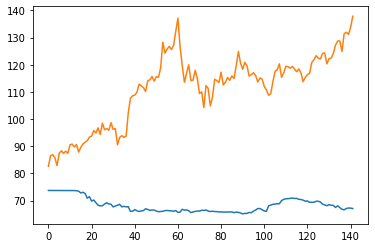







 36%|███▌      | 1801/5000 [7:44:49<17:16:33, 19.44s/it]





 36%|███▌      | 1802/5000 [7:45:06<16:31:49, 18.61s/it]





 36%|███▌      | 1803/5000 [7:45:22<16:00:50, 18.03s/it]





 36%|███▌      | 1804/5000 [7:45:39<15:35:49, 17.57s/it]





 36%|███▌      | 1805/5000 [7:45:56<15:23:26, 17.34s/it]





 36%|███▌      | 1806/5000 [7:46:12<15:09:40, 17.09s/it]





 36%|███▌      | 1807/5000 [7:46:29<15:01:38, 16.94s/it]





 36%|███▌      | 1808/5000 [7:46:45<14:55:41, 16.84s/it]





 36%|███▌      | 1809/5000 [7:47:02<14:51:45, 16.77s/it]





 36%|███▌      | 1810/5000 [7:47:19<14:53:40, 16.81s/it]





 36%|███▌      | 1811/5000 [7:47:35<14:42:15, 16.60s/it]





 36%|███▌      | 1812/5000 [7:47:51<14:27:43, 16.33s/it]





 36%|███▋      | 1813/5000 [7:48:07<14:31:25, 16.41s/it]





 36%|███▋      | 1814/5000 [7:48:24<14:41:25, 16.60s/it]





 36%|███▋      | 1815/5000 [7:48:41<14:46:49, 16.71s/it]





 36%|███▋      | 1816/5000 [7:48:58<14:42:40, 16.63s/it]





 3

MAE
60.226396044062916



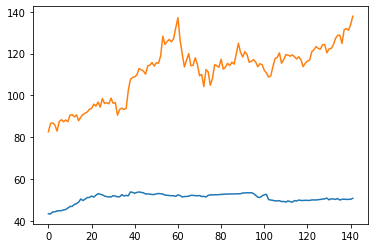







 37%|███▋      | 1851/5000 [7:58:56<17:29:58, 20.01s/it]





 37%|███▋      | 1852/5000 [7:59:13<16:47:34, 19.20s/it]





 37%|███▋      | 1853/5000 [7:59:30<16:12:13, 18.54s/it]





 37%|███▋      | 1854/5000 [7:59:48<15:48:19, 18.09s/it]





 37%|███▋      | 1855/5000 [8:00:05<15:35:43, 17.85s/it]





 37%|███▋      | 1856/5000 [8:00:22<15:28:10, 17.71s/it]





 37%|███▋      | 1857/5000 [8:00:39<15:17:49, 17.52s/it]





 37%|███▋      | 1858/5000 [8:00:56<15:12:22, 17.42s/it]





 37%|███▋      | 1859/5000 [8:01:14<15:07:32, 17.34s/it]





 37%|███▋      | 1860/5000 [8:01:31<15:06:45, 17.33s/it]





 37%|███▋      | 1861/5000 [8:01:48<14:58:33, 17.18s/it]





 37%|███▋      | 1862/5000 [8:02:05<14:52:02, 17.06s/it]





 37%|███▋      | 1863/5000 [8:02:21<14:40:34, 16.84s/it]





 37%|███▋      | 1864/5000 [8:02:38<14:38:12, 16.80s/it]





 37%|███▋      | 1865/5000 [8:02:55<14:41:24, 16.87s/it]





 37%|███▋      | 1866/5000 [8:03:11<14:38:55, 16.83s/it]





 3

MAE
64.32561887202802



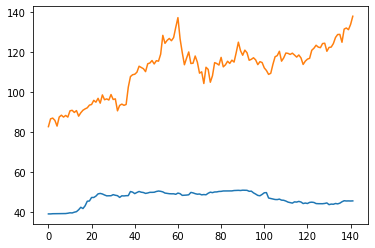







 38%|███▊      | 1901/5000 [8:13:10<17:00:06, 19.75s/it]





 38%|███▊      | 1902/5000 [8:13:26<16:13:56, 18.86s/it]





 38%|███▊      | 1903/5000 [8:13:43<15:37:21, 18.16s/it]





 38%|███▊      | 1904/5000 [8:14:00<15:17:02, 17.77s/it]





 38%|███▊      | 1905/5000 [8:14:17<15:12:37, 17.69s/it]





 38%|███▊      | 1906/5000 [8:14:34<14:55:33, 17.37s/it]





 38%|███▊      | 1907/5000 [8:14:50<14:39:32, 17.06s/it]





 38%|███▊      | 1908/5000 [8:15:07<14:32:09, 16.92s/it]





 38%|███▊      | 1909/5000 [8:15:24<14:31:42, 16.92s/it]





 38%|███▊      | 1910/5000 [8:15:41<14:42:01, 17.13s/it]





 38%|███▊      | 1911/5000 [8:15:59<14:42:28, 17.14s/it]





 38%|███▊      | 1912/5000 [8:16:16<14:41:31, 17.13s/it]





 38%|███▊      | 1913/5000 [8:16:33<14:41:50, 17.14s/it]





 38%|███▊      | 1914/5000 [8:16:49<14:29:02, 16.90s/it]





 38%|███▊      | 1915/5000 [8:17:06<14:29:53, 16.92s/it]





 38%|███▊      | 1916/5000 [8:17:23<14:26:35, 16.86s/it]





 3

MAE
66.85293307155624



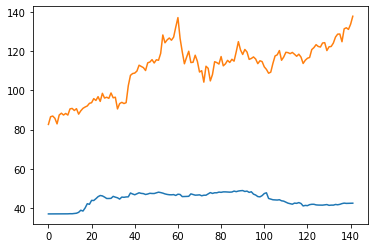







 39%|███▉      | 1951/5000 [8:27:21<16:40:06, 19.68s/it]





 39%|███▉      | 1952/5000 [8:27:38<16:03:24, 18.96s/it]





 39%|███▉      | 1953/5000 [8:27:55<15:32:25, 18.36s/it]





 39%|███▉      | 1954/5000 [8:28:12<15:05:00, 17.83s/it]





 39%|███▉      | 1955/5000 [8:28:29<14:56:41, 17.67s/it]





 39%|███▉      | 1956/5000 [8:28:46<14:42:26, 17.39s/it]





 39%|███▉      | 1957/5000 [8:29:03<14:36:10, 17.28s/it]





 39%|███▉      | 1958/5000 [8:29:20<14:31:19, 17.19s/it]





 39%|███▉      | 1959/5000 [8:29:37<14:27:30, 17.12s/it]





 39%|███▉      | 1960/5000 [8:29:54<14:28:01, 17.13s/it]





 39%|███▉      | 1961/5000 [8:30:11<14:22:39, 17.03s/it]





 39%|███▉      | 1962/5000 [8:30:28<14:21:14, 17.01s/it]





 39%|███▉      | 1963/5000 [8:30:45<14:18:41, 16.96s/it]





 39%|███▉      | 1964/5000 [8:31:01<14:16:10, 16.92s/it]





 39%|███▉      | 1965/5000 [8:31:18<14:13:24, 16.87s/it]





 39%|███▉      | 1966/5000 [8:31:35<14:06:30, 16.74s/it]





 3

MAE
68.95724564591598



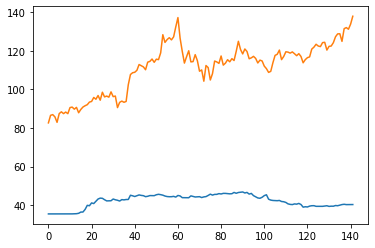







 40%|████      | 2001/5000 [8:41:34<16:33:21, 19.87s/it]





 40%|████      | 2002/5000 [8:41:50<15:44:05, 18.89s/it]





 40%|████      | 2003/5000 [8:42:07<15:14:18, 18.30s/it]





 40%|████      | 2004/5000 [8:42:24<14:55:45, 17.94s/it]





 40%|████      | 2005/5000 [8:42:42<14:46:36, 17.76s/it]





 40%|████      | 2006/5000 [8:42:59<14:37:28, 17.58s/it]





 40%|████      | 2007/5000 [8:43:16<14:28:45, 17.42s/it]





 40%|████      | 2008/5000 [8:43:33<14:16:29, 17.18s/it]





 40%|████      | 2009/5000 [8:43:49<14:09:36, 17.04s/it]





 40%|████      | 2010/5000 [8:44:06<14:11:34, 17.09s/it]





 40%|████      | 2011/5000 [8:44:23<14:07:10, 17.01s/it]





 40%|████      | 2012/5000 [8:44:40<13:59:37, 16.86s/it]





 40%|████      | 2013/5000 [8:44:57<13:58:53, 16.85s/it]





 40%|████      | 2014/5000 [8:45:13<13:57:28, 16.83s/it]





 40%|████      | 2015/5000 [8:45:30<13:55:04, 16.79s/it]





 40%|████      | 2016/5000 [8:45:47<13:58:10, 16.85s/it]





 4

MAE
49.35858849457286



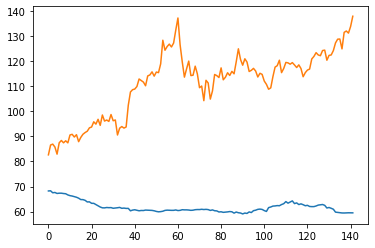







 41%|████      | 2051/5000 [8:56:04<16:15:42, 19.85s/it]





 41%|████      | 2052/5000 [8:56:21<15:31:22, 18.96s/it]





 41%|████      | 2053/5000 [8:56:38<15:08:05, 18.49s/it]





 41%|████      | 2054/5000 [8:56:55<14:44:51, 18.02s/it]





 41%|████      | 2055/5000 [8:57:12<14:27:54, 17.68s/it]





 41%|████      | 2056/5000 [8:57:29<14:15:39, 17.44s/it]





 41%|████      | 2057/5000 [8:57:46<14:11:25, 17.36s/it]





 41%|████      | 2058/5000 [8:58:03<14:07:38, 17.29s/it]





 41%|████      | 2059/5000 [8:58:20<13:57:38, 17.09s/it]





 41%|████      | 2060/5000 [8:58:37<14:00:15, 17.15s/it]





 41%|████      | 2061/5000 [8:58:54<13:51:36, 16.98s/it]





 41%|████      | 2062/5000 [8:59:11<13:47:34, 16.90s/it]





 41%|████▏     | 2063/5000 [8:59:28<13:53:01, 17.02s/it]





 41%|████▏     | 2064/5000 [8:59:44<13:46:37, 16.89s/it]





 41%|████▏     | 2065/5000 [9:00:02<13:49:51, 16.96s/it]





 41%|████▏     | 2066/5000 [9:00:18<13:48:17, 16.94s/it]





 4

MAE
46.560016787075675



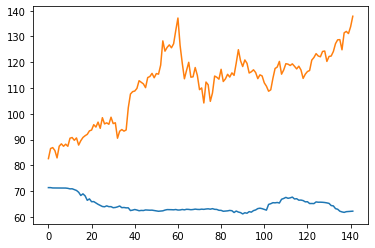







 42%|████▏     | 2101/5000 [9:10:24<16:03:33, 19.94s/it]





 42%|████▏     | 2102/5000 [9:10:42<15:27:13, 19.20s/it]





 42%|████▏     | 2103/5000 [9:11:00<15:07:47, 18.80s/it]





 42%|████▏     | 2104/5000 [9:11:17<14:48:09, 18.40s/it]





 42%|████▏     | 2105/5000 [9:11:35<14:39:09, 18.22s/it]





 42%|████▏     | 2106/5000 [9:11:52<14:20:22, 17.84s/it]





 42%|████▏     | 2107/5000 [9:12:09<14:15:50, 17.75s/it]





 42%|████▏     | 2108/5000 [9:12:27<14:14:10, 17.72s/it]





 42%|████▏     | 2109/5000 [9:12:45<14:12:27, 17.69s/it]





 42%|████▏     | 2110/5000 [9:13:03<14:19:13, 17.84s/it]





 42%|████▏     | 2111/5000 [9:13:21<14:16:15, 17.78s/it]





 42%|████▏     | 2112/5000 [9:13:38<14:12:16, 17.71s/it]





 42%|████▏     | 2113/5000 [9:13:55<14:05:36, 17.57s/it]





 42%|████▏     | 2114/5000 [9:14:12<13:50:22, 17.26s/it]





 42%|████▏     | 2115/5000 [9:14:29<13:53:42, 17.34s/it]





 42%|████▏     | 2116/5000 [9:14:46<13:50:02, 17.27s/it]





 4

MAE
44.26750569329129



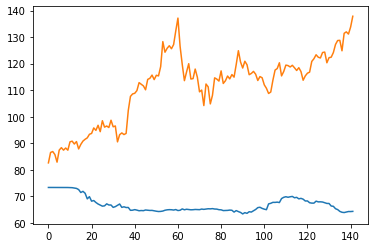







 43%|████▎     | 2151/5000 [9:24:55<15:57:10, 20.16s/it]





 43%|████▎     | 2152/5000 [9:25:13<15:19:29, 19.37s/it]





 43%|████▎     | 2153/5000 [9:25:30<14:44:04, 18.63s/it]





 43%|████▎     | 2154/5000 [9:25:46<14:14:17, 18.01s/it]





 43%|████▎     | 2155/5000 [9:26:03<13:54:06, 17.59s/it]





 43%|████▎     | 2156/5000 [9:26:19<13:37:59, 17.26s/it]





 43%|████▎     | 2157/5000 [9:26:35<13:23:49, 16.96s/it]





 43%|████▎     | 2158/5000 [9:26:52<13:18:18, 16.85s/it]





 43%|████▎     | 2159/5000 [9:27:09<13:14:07, 16.77s/it]





 43%|████▎     | 2160/5000 [9:27:26<13:18:47, 16.88s/it]





 43%|████▎     | 2161/5000 [9:27:42<13:12:42, 16.75s/it]





 43%|████▎     | 2162/5000 [9:27:59<13:11:05, 16.73s/it]





 43%|████▎     | 2163/5000 [9:28:15<13:01:34, 16.53s/it]





 43%|████▎     | 2164/5000 [9:28:31<12:57:18, 16.45s/it]





 43%|████▎     | 2165/5000 [9:28:48<13:00:45, 16.52s/it]





 43%|████▎     | 2166/5000 [9:29:04<13:00:28, 16.52s/it]





 4

MAE
63.790169024658894



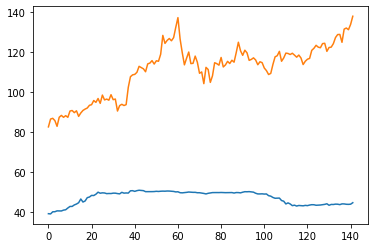







 44%|████▍     | 2201/5000 [9:38:53<15:01:46, 19.33s/it]





 44%|████▍     | 2202/5000 [9:39:09<14:23:23, 18.51s/it]





 44%|████▍     | 2203/5000 [9:39:26<13:53:42, 17.88s/it]





 44%|████▍     | 2204/5000 [9:39:42<13:35:56, 17.51s/it]





 44%|████▍     | 2205/5000 [9:40:00<13:30:30, 17.40s/it]





 44%|████▍     | 2206/5000 [9:40:16<13:20:08, 17.18s/it]





 44%|████▍     | 2207/5000 [9:40:33<13:15:43, 17.09s/it]





 44%|████▍     | 2208/5000 [9:40:50<13:09:03, 16.96s/it]





 44%|████▍     | 2209/5000 [9:41:06<13:02:44, 16.83s/it]





 44%|████▍     | 2210/5000 [9:41:23<13:05:41, 16.90s/it]





 44%|████▍     | 2211/5000 [9:41:40<13:01:25, 16.81s/it]





 44%|████▍     | 2212/5000 [9:41:57<13:00:01, 16.79s/it]





 44%|████▍     | 2213/5000 [9:42:14<13:01:29, 16.82s/it]





 44%|████▍     | 2214/5000 [9:42:30<12:52:36, 16.64s/it]





 44%|████▍     | 2215/5000 [9:42:45<12:29:08, 16.14s/it]





 44%|████▍     | 2216/5000 [9:43:00<12:15:27, 15.85s/it]





 4

MAE
66.16911038599217



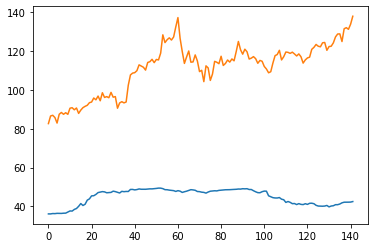







 45%|████▌     | 2251/5000 [9:51:59<13:22:55, 17.52s/it]





 45%|████▌     | 2252/5000 [9:52:14<12:51:25, 16.84s/it]





 45%|████▌     | 2253/5000 [9:52:29<12:24:15, 16.26s/it]





 45%|████▌     | 2254/5000 [9:52:44<12:11:21, 15.98s/it]





 45%|████▌     | 2255/5000 [9:53:00<12:05:40, 15.86s/it]





 45%|████▌     | 2256/5000 [9:53:15<11:57:27, 15.69s/it]





 45%|████▌     | 2257/5000 [9:53:30<11:51:39, 15.57s/it]





 45%|████▌     | 2258/5000 [9:53:46<11:47:54, 15.49s/it]





 45%|████▌     | 2259/5000 [9:54:00<11:33:54, 15.19s/it]





 45%|████▌     | 2260/5000 [9:54:15<11:27:27, 15.05s/it]





 45%|████▌     | 2261/5000 [9:54:30<11:28:46, 15.09s/it]





 45%|████▌     | 2262/5000 [9:54:45<11:29:21, 15.11s/it]





 45%|████▌     | 2263/5000 [9:55:01<11:31:24, 15.16s/it]





 45%|████▌     | 2264/5000 [9:55:16<11:32:41, 15.19s/it]





 45%|████▌     | 2265/5000 [9:55:31<11:29:50, 15.13s/it]





 45%|████▌     | 2266/5000 [9:55:45<11:22:53, 14.99s/it]





 4

MAE
52.301871763676004



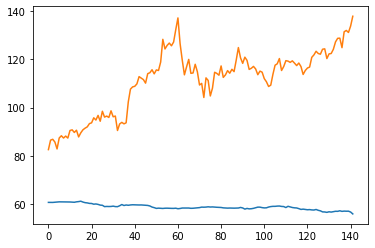







 46%|████▌     | 2301/5000 [10:04:43<13:08:32, 17.53s/it]





 46%|████▌     | 2302/5000 [10:04:58<12:36:57, 16.83s/it]





 46%|████▌     | 2303/5000 [10:05:13<12:09:48, 16.24s/it]





 46%|████▌     | 2304/5000 [10:05:28<11:51:53, 15.84s/it]





 46%|████▌     | 2305/5000 [10:05:44<11:46:50, 15.74s/it]





 46%|████▌     | 2306/5000 [10:05:59<11:37:11, 15.53s/it]





 46%|████▌     | 2307/5000 [10:06:14<11:31:07, 15.40s/it]





 46%|████▌     | 2308/5000 [10:06:29<11:23:47, 15.24s/it]





 46%|████▌     | 2309/5000 [10:06:43<11:17:44, 15.11s/it]





 46%|████▌     | 2310/5000 [10:06:59<11:19:12, 15.15s/it]





 46%|████▌     | 2311/5000 [10:07:14<11:15:55, 15.08s/it]





 46%|████▌     | 2312/5000 [10:07:29<11:17:41, 15.13s/it]





 46%|████▋     | 2313/5000 [10:07:44<11:19:42, 15.18s/it]





 46%|████▋     | 2314/5000 [10:07:59<11:15:51, 15.10s/it]





 46%|████▋     | 2315/5000 [10:08:14<11:16:07, 15.11s/it]





 46%|████▋     | 2316/5000 [10:08:29<11:09:24, 14

MAE
46.06713288991218



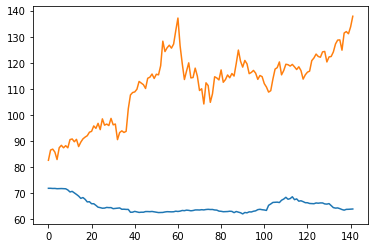







 47%|████▋     | 2351/5000 [10:17:19<12:36:01, 17.12s/it]





 47%|████▋     | 2352/5000 [10:17:33<12:06:43, 16.47s/it]





 47%|████▋     | 2353/5000 [10:17:49<11:48:37, 16.06s/it]





 47%|████▋     | 2354/5000 [10:18:03<11:29:16, 15.63s/it]





 47%|████▋     | 2355/5000 [10:18:18<11:22:30, 15.48s/it]





 47%|████▋     | 2356/5000 [10:18:33<11:13:00, 15.27s/it]





 47%|████▋     | 2357/5000 [10:18:48<11:11:12, 15.24s/it]





 47%|████▋     | 2358/5000 [10:19:03<11:06:57, 15.15s/it]





 47%|████▋     | 2359/5000 [10:19:18<11:03:28, 15.07s/it]





 47%|████▋     | 2360/5000 [10:19:33<11:03:33, 15.08s/it]





 47%|████▋     | 2361/5000 [10:19:48<11:01:38, 15.04s/it]





 47%|████▋     | 2362/5000 [10:20:03<11:01:30, 15.05s/it]





 47%|████▋     | 2363/5000 [10:20:18<11:01:06, 15.04s/it]





 47%|████▋     | 2364/5000 [10:20:33<10:57:00, 14.95s/it]





 47%|████▋     | 2365/5000 [10:20:48<10:57:33, 14.97s/it]





 47%|████▋     | 2366/5000 [10:21:03<10:55:58, 14

MAE
43.85825382204796



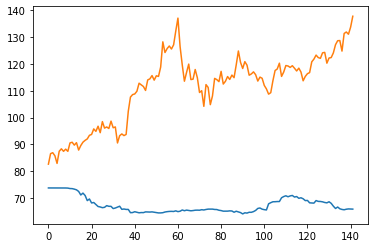







 48%|████▊     | 2401/5000 [10:29:51<12:29:16, 17.30s/it]





 48%|████▊     | 2402/5000 [10:30:06<11:55:32, 16.53s/it]





 48%|████▊     | 2403/5000 [10:30:20<11:33:37, 16.03s/it]





 48%|████▊     | 2404/5000 [10:30:35<11:20:38, 15.73s/it]





 48%|████▊     | 2405/5000 [10:30:51<11:16:25, 15.64s/it]





 48%|████▊     | 2406/5000 [10:31:06<11:08:28, 15.46s/it]





 48%|████▊     | 2407/5000 [10:31:21<10:58:43, 15.24s/it]





 48%|████▊     | 2408/5000 [10:31:36<10:54:09, 15.14s/it]





 48%|████▊     | 2409/5000 [10:31:51<10:53:54, 15.14s/it]





 48%|████▊     | 2410/5000 [10:32:06<10:56:56, 15.22s/it]





 48%|████▊     | 2411/5000 [10:32:21<10:53:52, 15.15s/it]





 48%|████▊     | 2412/5000 [10:32:36<10:49:47, 15.06s/it]





 48%|████▊     | 2413/5000 [10:32:51<10:45:30, 14.97s/it]





 48%|████▊     | 2414/5000 [10:33:06<10:46:04, 14.99s/it]





 48%|████▊     | 2415/5000 [10:33:21<10:51:26, 15.12s/it]





 48%|████▊     | 2416/5000 [10:33:36<10:50:09, 15

MAE
48.1572399346157



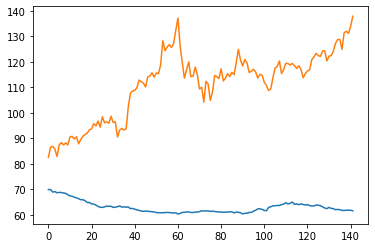







 49%|████▉     | 2451/5000 [10:42:30<12:12:10, 17.23s/it]





 49%|████▉     | 2452/5000 [10:42:44<11:37:48, 16.43s/it]





 49%|████▉     | 2453/5000 [10:42:59<11:14:12, 15.88s/it]





 49%|████▉     | 2454/5000 [10:43:14<11:01:23, 15.59s/it]





 49%|████▉     | 2455/5000 [10:43:29<10:58:09, 15.52s/it]





 49%|████▉     | 2456/5000 [10:43:44<10:45:52, 15.23s/it]





 49%|████▉     | 2457/5000 [10:43:58<10:38:55, 15.07s/it]





 49%|████▉     | 2458/5000 [10:44:13<10:30:15, 14.88s/it]





 49%|████▉     | 2459/5000 [10:44:28<10:32:27, 14.93s/it]





 49%|████▉     | 2460/5000 [10:44:43<10:36:11, 15.03s/it]





 49%|████▉     | 2461/5000 [10:44:58<10:29:29, 14.88s/it]





 49%|████▉     | 2462/5000 [10:45:13<10:35:07, 15.01s/it]





 49%|████▉     | 2463/5000 [10:45:28<10:35:56, 15.04s/it]





 49%|████▉     | 2464/5000 [10:45:43<10:38:12, 15.10s/it]





 49%|████▉     | 2465/5000 [10:45:59<10:40:01, 15.15s/it]





 49%|████▉     | 2466/5000 [10:46:13<10:27:20, 14

MAE
62.97193612567809



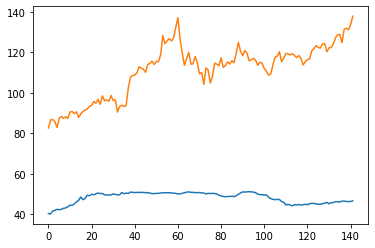







 50%|█████     | 2501/5000 [10:55:38<13:20:05, 19.21s/it]





 50%|█████     | 2502/5000 [10:55:56<13:01:48, 18.78s/it]





 50%|█████     | 2503/5000 [10:56:14<12:48:15, 18.46s/it]





 50%|█████     | 2504/5000 [10:56:32<12:42:16, 18.32s/it]





 50%|█████     | 2505/5000 [10:56:49<12:28:44, 18.01s/it]





 50%|█████     | 2506/5000 [10:57:06<12:19:37, 17.79s/it]





 50%|█████     | 2507/5000 [10:57:24<12:22:09, 17.86s/it]





 50%|█████     | 2508/5000 [10:57:41<12:01:56, 17.38s/it]





 50%|█████     | 2509/5000 [10:57:59<12:11:28, 17.62s/it]





 50%|█████     | 2510/5000 [10:58:17<12:19:51, 17.83s/it]





 50%|█████     | 2511/5000 [10:58:35<12:22:43, 17.90s/it]





 50%|█████     | 2512/5000 [10:58:53<12:22:51, 17.91s/it]





 50%|█████     | 2513/5000 [10:59:11<12:24:29, 17.96s/it]





 50%|█████     | 2514/5000 [10:59:29<12:19:43, 17.85s/it]





 50%|█████     | 2515/5000 [10:59:47<12:24:34, 17.98s/it]





 50%|█████     | 2516/5000 [11:00:05<12:20:56, 17

MAE
65.75502886623397



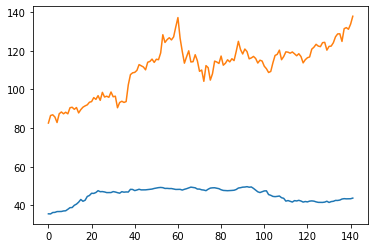







 51%|█████     | 2551/5000 [11:09:49<12:05:38, 17.78s/it]





 51%|█████     | 2552/5000 [11:10:05<11:41:05, 17.18s/it]





 51%|█████     | 2553/5000 [11:10:19<11:13:42, 16.52s/it]





 51%|█████     | 2554/5000 [11:10:35<11:01:58, 16.24s/it]





 51%|█████     | 2555/5000 [11:10:51<11:00:11, 16.20s/it]





 51%|█████     | 2556/5000 [11:11:07<10:51:19, 15.99s/it]





 51%|█████     | 2557/5000 [11:11:22<10:46:32, 15.88s/it]





 51%|█████     | 2558/5000 [11:11:38<10:40:42, 15.74s/it]





 51%|█████     | 2559/5000 [11:11:54<10:41:26, 15.77s/it]





 51%|█████     | 2560/5000 [11:12:10<10:47:37, 15.93s/it]





 51%|█████     | 2561/5000 [11:12:25<10:42:21, 15.80s/it]





 51%|█████     | 2562/5000 [11:12:41<10:39:43, 15.74s/it]





 51%|█████▏    | 2563/5000 [11:12:57<10:37:56, 15.71s/it]





 51%|█████▏    | 2564/5000 [11:13:12<10:32:35, 15.58s/it]





 51%|█████▏    | 2565/5000 [11:13:27<10:26:57, 15.45s/it]





 51%|█████▏    | 2566/5000 [11:13:42<10:21:44, 15

MAE
46.77277792728117



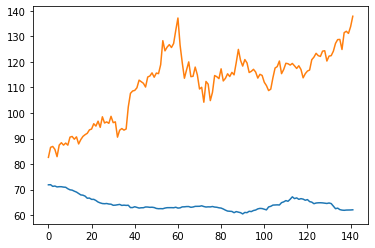







 52%|█████▏    | 2601/5000 [11:23:25<13:57:27, 20.95s/it]





 52%|█████▏    | 2602/5000 [11:23:44<13:31:31, 20.31s/it]





 52%|█████▏    | 2603/5000 [11:24:02<13:07:46, 19.72s/it]





 52%|█████▏    | 2604/5000 [11:24:20<12:42:02, 19.08s/it]





 52%|█████▏    | 2605/5000 [11:24:37<12:23:50, 18.63s/it]





 52%|█████▏    | 2606/5000 [11:24:55<12:09:13, 18.28s/it]





 52%|█████▏    | 2607/5000 [11:25:12<11:55:15, 17.93s/it]





 52%|█████▏    | 2608/5000 [11:25:28<11:40:18, 17.57s/it]





 52%|█████▏    | 2609/5000 [11:25:46<11:35:37, 17.46s/it]





 52%|█████▏    | 2610/5000 [11:26:04<11:45:37, 17.71s/it]





 52%|█████▏    | 2611/5000 [11:26:22<11:44:02, 17.68s/it]





 52%|█████▏    | 2612/5000 [11:26:40<11:56:27, 18.00s/it]





 52%|█████▏    | 2613/5000 [11:26:58<11:50:52, 17.87s/it]





 52%|█████▏    | 2614/5000 [11:27:16<11:57:14, 18.04s/it]





 52%|█████▏    | 2615/5000 [11:27:36<12:13:14, 18.45s/it]





 52%|█████▏    | 2616/5000 [11:27:54<12:06:20, 18

MAE
65.05473840121486



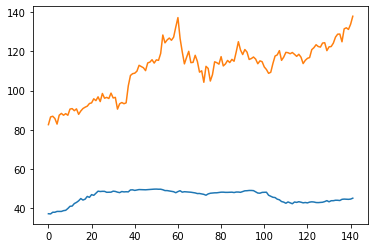







 53%|█████▎    | 2651/5000 [11:38:37<13:07:22, 20.11s/it]





 53%|█████▎    | 2652/5000 [11:38:54<12:30:09, 19.17s/it]





 53%|█████▎    | 2653/5000 [11:39:11<12:05:40, 18.55s/it]





 53%|█████▎    | 2654/5000 [11:39:28<11:47:02, 18.08s/it]





 53%|█████▎    | 2655/5000 [11:39:45<11:37:03, 17.84s/it]





 53%|█████▎    | 2656/5000 [11:40:02<11:22:55, 17.48s/it]





 53%|█████▎    | 2657/5000 [11:40:19<11:14:31, 17.27s/it]





 53%|█████▎    | 2658/5000 [11:40:35<11:09:07, 17.14s/it]





 53%|█████▎    | 2659/5000 [11:40:52<11:01:24, 16.95s/it]





 53%|█████▎    | 2660/5000 [11:41:09<10:57:44, 16.87s/it]





 53%|█████▎    | 2661/5000 [11:41:25<10:51:39, 16.72s/it]





 53%|█████▎    | 2662/5000 [11:41:42<10:49:58, 16.68s/it]





 53%|█████▎    | 2663/5000 [11:41:58<10:47:28, 16.62s/it]





 53%|█████▎    | 2664/5000 [11:42:14<10:39:34, 16.43s/it]





 53%|█████▎    | 2665/5000 [11:42:32<11:01:34, 17.00s/it]





 53%|█████▎    | 2666/5000 [11:42:50<11:03:21, 17

MAE
46.39915930438043



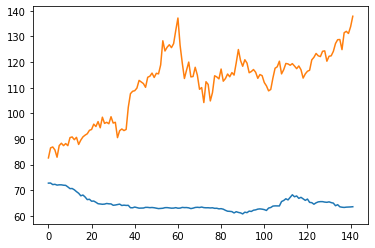







 54%|█████▍    | 2701/5000 [11:53:06<13:51:14, 21.69s/it]





 54%|█████▍    | 2702/5000 [11:53:24<13:13:14, 20.71s/it]





 54%|█████▍    | 2703/5000 [11:53:43<12:46:37, 20.03s/it]





 54%|█████▍    | 2704/5000 [11:54:01<12:29:54, 19.60s/it]





 54%|█████▍    | 2705/5000 [11:54:22<12:41:15, 19.90s/it]





 54%|█████▍    | 2706/5000 [11:54:40<12:24:12, 19.47s/it]





 54%|█████▍    | 2707/5000 [11:54:59<12:10:17, 19.11s/it]





 54%|█████▍    | 2708/5000 [11:55:17<12:01:47, 18.90s/it]





 54%|█████▍    | 2709/5000 [11:55:36<11:59:47, 18.85s/it]





 54%|█████▍    | 2710/5000 [11:55:55<11:59:06, 18.84s/it]





 54%|█████▍    | 2711/5000 [11:56:13<11:51:25, 18.65s/it]





 54%|█████▍    | 2712/5000 [11:56:31<11:47:54, 18.56s/it]





 54%|█████▍    | 2713/5000 [11:56:48<11:25:24, 17.98s/it]





 54%|█████▍    | 2714/5000 [11:57:06<11:27:38, 18.05s/it]





 54%|█████▍    | 2715/5000 [11:57:26<11:47:39, 18.58s/it]





 54%|█████▍    | 2716/5000 [11:57:44<11:38:54, 18

MAE
47.925121650417104



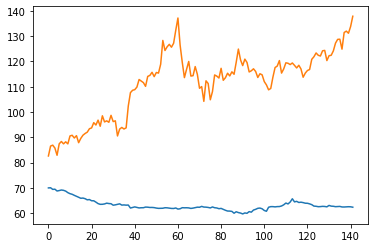







 55%|█████▌    | 2751/5000 [12:08:29<12:33:19, 20.10s/it]





 55%|█████▌    | 2752/5000 [12:08:46<11:59:34, 19.21s/it]





 55%|█████▌    | 2753/5000 [12:09:03<11:31:48, 18.47s/it]





 55%|█████▌    | 2754/5000 [12:09:20<11:18:03, 18.11s/it]





 55%|█████▌    | 2755/5000 [12:09:38<11:11:26, 17.94s/it]





 55%|█████▌    | 2756/5000 [12:09:55<11:03:45, 17.75s/it]





 55%|█████▌    | 2757/5000 [12:10:12<10:53:47, 17.49s/it]





 55%|█████▌    | 2758/5000 [12:10:29<10:43:15, 17.21s/it]





 55%|█████▌    | 2759/5000 [12:10:45<10:36:38, 17.05s/it]





 55%|█████▌    | 2760/5000 [12:11:02<10:27:59, 16.82s/it]





 55%|█████▌    | 2761/5000 [12:11:18<10:20:57, 16.64s/it]





 55%|█████▌    | 2762/5000 [12:11:34<10:15:37, 16.50s/it]





 55%|█████▌    | 2763/5000 [12:11:50<10:07:49, 16.30s/it]





 55%|█████▌    | 2764/5000 [12:12:06<10:07:53, 16.31s/it]





 55%|█████▌    | 2765/5000 [12:12:23<10:13:56, 16.48s/it]





 55%|█████▌    | 2766/5000 [12:12:39<10:06:23, 16

MAE
48.49728709931778



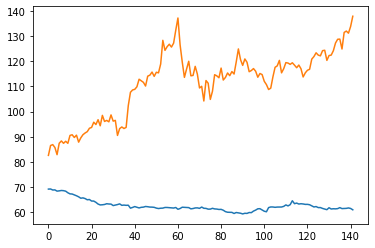







 56%|█████▌    | 2801/5000 [12:23:27<14:13:11, 23.28s/it]





 56%|█████▌    | 2802/5000 [12:23:47<13:29:32, 22.10s/it]





 56%|█████▌    | 2803/5000 [12:24:07<13:06:19, 21.47s/it]





 56%|█████▌    | 2804/5000 [12:24:26<12:45:22, 20.91s/it]





 56%|█████▌    | 2805/5000 [12:24:48<12:48:14, 21.00s/it]





 56%|█████▌    | 2806/5000 [12:25:07<12:35:26, 20.66s/it]





 56%|█████▌    | 2807/5000 [12:25:27<12:19:18, 20.23s/it]





 56%|█████▌    | 2808/5000 [12:25:46<12:09:37, 19.97s/it]





 56%|█████▌    | 2809/5000 [12:26:05<11:56:14, 19.61s/it]





 56%|█████▌    | 2810/5000 [12:26:24<11:46:19, 19.35s/it]





 56%|█████▌    | 2811/5000 [12:26:42<11:40:52, 19.21s/it]





 56%|█████▌    | 2812/5000 [12:27:01<11:31:27, 18.96s/it]





 56%|█████▋    | 2813/5000 [12:27:21<11:40:39, 19.22s/it]





 56%|█████▋    | 2814/5000 [12:27:40<11:40:57, 19.24s/it]





 56%|█████▋    | 2815/5000 [12:28:00<11:48:18, 19.45s/it]





 56%|█████▋    | 2816/5000 [12:28:19<11:47:36, 19

MAE
47.57211316524091



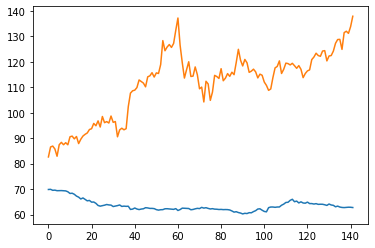







 57%|█████▋    | 2851/5000 [12:42:00<17:00:30, 28.49s/it]





 57%|█████▋    | 2852/5000 [12:42:23<16:01:45, 26.86s/it]





 57%|█████▋    | 2853/5000 [12:42:45<15:09:46, 25.42s/it]





 57%|█████▋    | 2854/5000 [12:43:07<14:30:01, 24.32s/it]





 57%|█████▋    | 2855/5000 [12:43:29<14:11:30, 23.82s/it]





 57%|█████▋    | 2856/5000 [12:43:51<13:52:32, 23.30s/it]





 57%|█████▋    | 2857/5000 [12:44:13<13:38:12, 22.91s/it]





 57%|█████▋    | 2858/5000 [12:44:36<13:30:37, 22.71s/it]





 57%|█████▋    | 2859/5000 [12:44:59<13:37:33, 22.91s/it]





 57%|█████▋    | 2860/5000 [12:45:24<14:00:26, 23.56s/it]





 57%|█████▋    | 2861/5000 [12:45:48<14:07:01, 23.76s/it]





 57%|█████▋    | 2862/5000 [12:46:12<14:08:11, 23.80s/it]





 57%|█████▋    | 2863/5000 [12:46:36<14:10:46, 23.89s/it]





 57%|█████▋    | 2864/5000 [12:47:00<14:08:46, 23.84s/it]





 57%|█████▋    | 2865/5000 [12:47:24<14:04:43, 23.74s/it]





 57%|█████▋    | 2866/5000 [12:47:46<13:55:21, 23

MAE
59.19241077180313



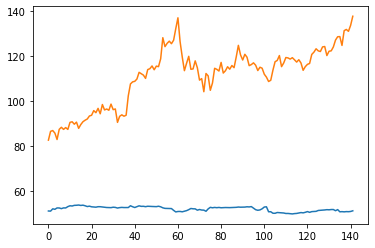







 58%|█████▊    | 2901/5000 [13:00:09<14:39:09, 25.13s/it]





 58%|█████▊    | 2902/5000 [13:00:30<14:01:03, 24.05s/it]





 58%|█████▊    | 2903/5000 [13:00:51<13:31:25, 23.22s/it]





 58%|█████▊    | 2904/5000 [13:01:13<13:14:52, 22.75s/it]





 58%|█████▊    | 2905/5000 [13:01:35<13:08:31, 22.58s/it]





 58%|█████▊    | 2906/5000 [13:01:57<12:58:35, 22.31s/it]





 58%|█████▊    | 2907/5000 [13:02:18<12:48:22, 22.03s/it]





 58%|█████▊    | 2908/5000 [13:02:39<12:37:30, 21.73s/it]





 58%|█████▊    | 2909/5000 [13:03:01<12:33:06, 21.61s/it]





 58%|█████▊    | 2910/5000 [13:03:21<12:21:51, 21.30s/it]





 58%|█████▊    | 2911/5000 [13:03:40<11:52:43, 20.47s/it]





 58%|█████▊    | 2912/5000 [13:03:58<11:34:12, 19.95s/it]





 58%|█████▊    | 2913/5000 [13:04:18<11:28:24, 19.79s/it]





 58%|█████▊    | 2914/5000 [13:04:37<11:26:28, 19.75s/it]





 58%|█████▊    | 2915/5000 [13:04:57<11:23:13, 19.66s/it]





 58%|█████▊    | 2916/5000 [13:05:17<11:25:50, 19

MAE
52.085795033673186



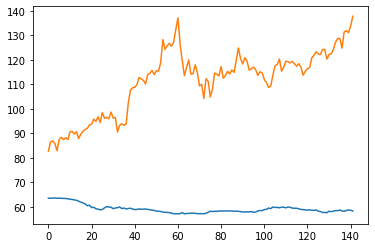







 59%|█████▉    | 2951/5000 [13:16:43<12:07:21, 21.30s/it]





 59%|█████▉    | 2952/5000 [13:17:00<11:27:46, 20.15s/it]





 59%|█████▉    | 2953/5000 [13:17:18<10:59:50, 19.34s/it]





 59%|█████▉    | 2954/5000 [13:17:36<10:42:08, 18.83s/it]





 59%|█████▉    | 2955/5000 [13:17:54<10:35:33, 18.65s/it]





 59%|█████▉    | 2956/5000 [13:18:12<10:26:42, 18.40s/it]





 59%|█████▉    | 2957/5000 [13:18:30<10:22:42, 18.29s/it]





 59%|█████▉    | 2958/5000 [13:18:48<10:18:59, 18.19s/it]





 59%|█████▉    | 2959/5000 [13:19:06<10:20:04, 18.23s/it]





 59%|█████▉    | 2960/5000 [13:19:25<10:31:32, 18.57s/it]





 59%|█████▉    | 2961/5000 [13:19:45<10:39:48, 18.83s/it]





 59%|█████▉    | 2962/5000 [13:20:05<10:50:13, 19.14s/it]





 59%|█████▉    | 2963/5000 [13:20:24<10:51:26, 19.19s/it]





 59%|█████▉    | 2964/5000 [13:20:44<10:59:06, 19.42s/it]





 59%|█████▉    | 2965/5000 [13:21:04<11:00:59, 19.49s/it]





 59%|█████▉    | 2966/5000 [13:21:24<11:11:40, 19

KeyboardInterrupt: 

In [51]:
returns = run_GAN()

In [ ]:
returns_generated = returns[0]
returns_true = returns[1]

In [ ]:
plt.plot(returns_generated, label = 'generated')
plt.plot(returns_true, label = 'true')
plt.legend()

In [605]:
#MAE
mean_absolute_error(returns_generated, returns_true)

18.175057003698715

In [606]:
#calculate generated and real returns
returns_percent_generated = []
for i in range (1, len(returns_generated)):
    returns_percent_generated.append( (returns_generated[i] - returns_generated[i-1])/returns_generated[i-1])
returns_percent_true= []
for i in range (1, len(returns_true)):
    returns_percent_true.append( (returns_true[i] - returns_true[i-1])/returns_true[i-1])

In [607]:
#trading strategy: buy if positive, nothing if negative
strategy_returns = []
for i in range (len(returns_percent_true)):
    if (returns_percent_generated[i] > 0):
        strategy_returns.append(returns_percent_true[i])
    else:
        strategy_returns.append(0)

1.9137289319462578
1.4325411274753184
0.00010692395144771673
0.20345949183619325
0.15071056330039215
-0.09023120905347894
0.30962343096234307


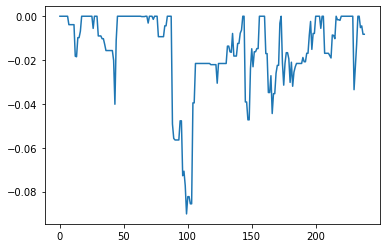

In [615]:
#eval strategy returns

#cumualtive reeturns real
cum_returns_real = 1
cum_ret_real = []
for i in range (len(returns_percent_true)):
    cum_returns_real  = cum_returns_real * (1 + returns_percent_true[i])
    cum_ret_real.append(cum_returns_real)
print (cum_returns_real)

#cumulative returns
cum_returns = 1
cum_ret = []
for i in range (len(strategy_returns)):
    cum_returns  = cum_returns * (1 + strategy_returns[i])
    cum_ret.append(cum_returns)
print (cum_returns)

#variance
variance = np.var(strategy_returns)
print (variance)

#sharpe real
std = np.std(returns_percent_true)
rfr = 0
sharpe = (np.average(returns_percent_true)- rfr)/std
print (sharpe)

#sharpe
std = np.std(strategy_returns)
rfr = 0
sharpe = (np.average(strategy_returns) - rfr)/std
print (sharpe)

#drawdown
previous_peaks = np.maximum.accumulate(cum_ret)
drawdown = (cum_ret-previous_peaks)/previous_peaks
max_drawdown = np.ndarray.min(drawdown)
print (max_drawdown)
plt.plot(drawdown)

#turnover
turnover = 0
for pred in strategy_returns:
    if (pred > 0):
        turnover += 1
turnover = turnover/len(strategy_returns)
print (turnover)

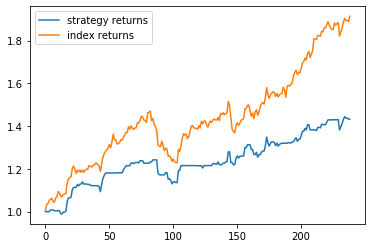

In [616]:
plt.plot(cum_ret, label = 'strategy returns')
plt.plot(cum_ret_real, label = 'index returns')
plt.legend()

In [612]:
sharpe = (np.average(strategy_returns) - 1 - rfr)/std
print (sharpe)



-96.55731129591832


In [618]:
np.var(strategy_returns)*100

0.010692395144771674

In [614]:
std

0.010340403833879833